# Setup

In [3]:
from os.path import join as opj
import os
import json
import numpy as np
import scipy as sp
import seaborn as sns
from scipy.io import loadmat
from copy import deepcopy

from nipype.interfaces.fsl import Smooth, FLIRT, ApplyMask, maths
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Threshold
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.interfaces.ants import ApplyTransforms, WarpImageMultiTransform
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node, MapNode
from nipype.utils.filemanip import loadpkl
from nipype.caching import Memory
from bids.layout import BIDSLayout

import nibabel as nib
from nilearn.masking import apply_mask

from sklearn.model_selection import KFold

# prevent rounding when dividing integers
from __future__ import division

# plotting
import nilearn.plotting as nip
import matplotlib.pyplot as plt

# Setup folder structure

In [4]:
bids_dir = '/lab/Paul/ContIEM/bids/Nifti'
fs_dir = '/lab/Paul/ContIEM/bids/dockerout/out/freesurfer'
base_dir = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep'
out_dir = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output'
work_dir = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/working'
matlab_dir = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/matlab'

## load fmri parameters

In [5]:
layout = BIDSLayout(bids_dir)
TR = layout.get_tr() ## TR in seconds
print(layout.get_tr())
sub_list = layout.get_subjects()
print(layout.get_subjects())
print(layout.get_session())
print(layout.get_datatype())
ses1_tasks = layout.get_tasks(session='1')
ses2_tasks = layout.get_tasks(session='2')
print(layout.get_tasks())
print(layout.get(subject='101',suffix='bold',task='colorgray',extension=['nii','nii.gz'],return_type='file'))

2.0
['101', '102', '103']
['1', '2']
['anat', 'func']
['colorencoder', 'colorgray', 'objectscram', 'retmap', 'sizejudge']
[u'/lab/Paul/ContIEM/bids/Nifti/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-001_bold.nii.gz', u'/lab/Paul/ContIEM/bids/Nifti/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-002_bold.nii.gz']


# Showing how nipype works

In [73]:
dg = DataGrabber()
dg.inputs.template = base_dir + '/sub-101/ses-1/func/*colorgray*T1w*preproc_bold*.nii.gz'
dg.inputs.sort_filelist = True

dg.run().outputs


outfiles = [u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-001_space-T1w_desc-preproc_bold.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-002_space-T1w_desc-preproc_bold.nii.gz']

In [5]:
dg = Node(DataGrabber(), name='bg')
dg.inputs.template = base_dir + '/sub-101/ses-1/func/*colorgray*T1w*preproc_bold*.nii.gz'
dg.inputs.sort_filelist = True

dg.run().outputs


191004-10:35:02,673 nipype.workflow INFO:
	 [Node] Setting-up "bg" in "/tmp/tmp_KTy2N/bg".
191004-10:35:02,677 nipype.workflow INFO:
	 [Node] Running "bg" ("nipype.interfaces.io.DataGrabber")
191004-10:35:02,686 nipype.workflow INFO:
	 [Node] Finished "bg".



outfiles = [u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-001_space-T1w_desc-preproc_bold.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-002_space-T1w_desc-preproc_bold.nii.gz']

In [126]:
def printMe(paths):
    print("\n\nanalyzing " + str(paths) + "\n\n")
    return str(paths) + " analyzed!\n"
    
analyzeBOLD = Node(Function(function=printMe, input_names=["paths"],
                            output_names=["out_string"]), name="analyzeBOLD")

wf_demo = Workflow(name="wf_demo")
wf_demo.base_dir = out_dir
wf_demo.connect(dg, "outfiles", analyzeBOLD, "paths")

## alternative format (better for more complicated workflows):
#wf_demo.connect([
#    (dg, analyzeBOLD, [('outfiles', 'paths')])
#])

wf_demo.run()

191004-11:23:23,623 nipype.workflow INFO:
	 Workflow wf_demo settings: ['check', 'execution', 'logging', 'monitoring']
191004-11:23:23,628 nipype.workflow INFO:
	 Running serially.
191004-11:23:23,630 nipype.workflow INFO:
	 [Node] Setting-up "wf_demo.bg" in "/tmp/tmp_KTy2N/bg".
191004-11:23:23,637 nipype.workflow INFO:
	 [Node] Running "bg" ("nipype.interfaces.io.DataGrabber")
191004-11:23:23,646 nipype.workflow INFO:
	 [Node] Finished "wf_demo.bg".
191004-11:23:23,648 nipype.workflow INFO:
	 [Node] Setting-up "wf_demo.analyzeBOLD" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/wf_demo/analyzeBOLD".
191004-11:23:23,653 nipype.workflow INFO:
	 [Node] Cached "wf_demo.analyzeBOLD" - collecting precomputed outputs
191004-11:23:23,655 nipype.workflow INFO:
	 [Node] "wf_demo.analyzeBOLD" found cached.


In [136]:
! tree -L 4 -I '_*'

res = loadpkl(out_dir + '/wf_demo/analyzeBOLD/result_analyzeBOLD.pklz')

print(res.outputs.out_string)

.
├── output
│   └── wf_demo
│       ├── analyzeBOLD
│       │   └── result_analyzeBOLD.pklz
│       ├── d3.js
│       ├── graph1.json
│       ├── graph.json
│       └── index.html
└── processing_detailed.ipynb

3 directories, 6 files
[u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-001_space-T1w_desc-preproc_bold.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-002_space-T1w_desc-preproc_bold.nii.gz'] analyzed!



In [7]:
### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'ses_name', 'task_name'],
                      outfields=['mprage', 'func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mprage': [['subject_id','subject_id']],
                           'func': [['subject_id', 'ses_name', 'task_name']]}
dg.inputs.field_template = {'mprage': 'sub-%s/anat/sub-%s_desc-preproc_T1w.nii.gz',
                            'func': 'sub-%s/ses-%s/func/*task-%s*T1w*preproc_bold.nii.gz'}

dg.inputs.subject_id = ['101','102']
dg.inputs.task_name = 'colorgray'
dg.inputs.ses_name = '1'

dg.run().outputs

191004-09:45:55,86 nipype.workflow INFO:
	 [Node] Setting-up "dg" in "/tmp/tmp0FCRvo/dg".
191004-09:45:55,99 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191004-09:45:55,111 nipype.workflow INFO:
	 [Node] Finished "dg".



func = [[u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-001_space-T1w_desc-preproc_bold.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-colorgray_run-002_space-T1w_desc-preproc_bold.nii.gz'], [u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/ses-1/func/sub-102_ses-1_task-colorgray_run-001_space-T1w_desc-preproc_bold.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/ses-1/func/sub-102_ses-1_task-colorgray_run-002_space-T1w_desc-preproc_bold.nii.gz']]
mprage = [u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/anat/sub-101_desc-preproc_T1w.nii.gz', u'/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/anat/sub-102_desc-preproc_T1w.nii.gz']

In [196]:
### DataGrabber Node ###
# redefining here because we already specified inputs in the above cell 
dg = Node(DataGrabber(infields=['subject_id', 'ses_name', 'task_name'],
                      outfields=['mprage', 'func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mprage': [['subject_id','subject_id']],
                           'func': [['subject_id', 'ses_name', 'task_name']]}
dg.inputs.field_template = {'mprage': 'sub-%s/anat/sub-%s_desc-preproc_T1w.nii.gz',
                            'func': 'sub-%s/ses-%s/func/*task-%s*T1w*preproc_bold.nii.gz'}

### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id', 'ses_name', 'task_name']),
                  name="infosource")
infosource.inputs.ses_name = "1"
infosource.inputs.task_name = 'colorencoder'
infosource.iterables = [('subject_id', ['101','102','103'])]

In [214]:
wf_demo2 = Workflow(name='wf_demo2')
wf_demo2.base_dir = out_dir
wf_demo2.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('ses_name','ses_name'),
                       ('task_name','task_name')]),
])

wf_demo2.run()

!tree -a 'output/wf_demo2' -L 2

res2 = loadpkl(out_dir + '/wf_demo2/_subject_id_101/dg/result_dg.pklz')
print('\nmprage:' + res2.outputs.mprage + '\n')
print('func:' + str(res2.outputs.func).replace("u'","\n") + '\n')

191004-12:08:06,314 nipype.workflow INFO:
	 Workflow wf_demo2 settings: ['check', 'execution', 'logging', 'monitoring']
191004-12:08:06,327 nipype.workflow INFO:
	 Running serially.
191004-12:08:06,329 nipype.workflow INFO:
	 [Node] Setting-up "wf_demo2.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/wf_demo2/_subject_id_103/dg".
191004-12:08:06,336 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191004-12:08:06,347 nipype.workflow INFO:
	 [Node] Finished "wf_demo2.dg".
191004-12:08:06,348 nipype.workflow INFO:
	 [Node] Setting-up "wf_demo2.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/wf_demo2/_subject_id_101/dg".
191004-12:08:06,355 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191004-12:08:06,365 nipype.workflow INFO:
	 [Node] Finished "wf_demo2.dg".
191004-12:08:06,367 nipype.workflow INFO:
	 [Node] Setting-up "wf_demo2.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/

191004-12:50:07,505 nipype.workflow INFO:
	 Generated workflow graph: /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/wf_demo2/graph.png (graph2use=flat, simple_form=True).


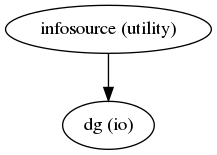

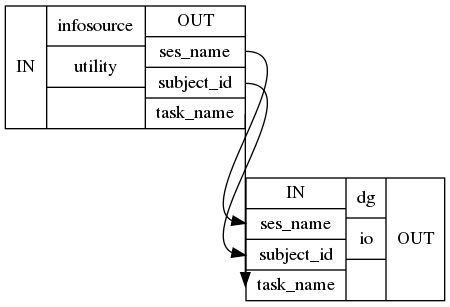

In [215]:
# Create preproc output graph
wf_demo2.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
display(Image(filename=opj(wf_demo2.base_dir, 'wf_demo2', 'graph.png')))
Image(filename=opj(wf_demo2.base_dir, 'wf_demo2', 'graph_detailed.png'))

# Preprocessing

## Smoothing

In [12]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', sub_list),
                        ('task_name', ['colorencoder', 'colorgray', 'objectscram', 'sizejudge'])]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'func': 'sub-%s/ses-*/func/*task-%s*T1w*preproc_bold.nii.gz'}

### Smooth Node ###
smooth = MapNode(Smooth(),name='smooth',iterfield=['in_file'])
smooth.inputs.fwhm = 4

In [13]:
smooth_wf = Workflow(name='smooth_wf')
smooth_wf.base_dir = out_dir
smooth_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (dg, smooth, [('func','in_file')]),
])

smooth_wf.run()


191006-12:25:29,886 nipype.workflow INFO:
	 Workflow smooth_wf settings: ['check', 'execution', 'logging', 'monitoring']
191006-12:25:29,907 nipype.workflow INFO:
	 Running serially.
191006-12:25:29,909 nipype.workflow INFO:
	 [Node] Setting-up "smooth_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_colorgray/dg".
191006-12:25:29,916 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191006-12:25:29,927 nipype.workflow INFO:
	 [Node] Finished "smooth_wf.dg".
191006-12:25:29,930 nipype.workflow INFO:
	 [Node] Setting-up "smooth_wf.smooth" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_colorgray/smooth".
191006-12:25:29,941 nipype.workflow INFO:
	 [Node] Setting-up "_smooth0" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_colorgray/smooth/mapflow/_smooth0".
191006-12:25:29,946 nipype.workflow INF

191006-12:28:10,266 nipype.workflow INFO:
	 [Node] Setting-up "_smooth1" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_sizejudge/smooth/mapflow/_smooth1".
191006-12:28:10,271 nipype.workflow INFO:
	 [Node] Running "_smooth1" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-2/func/sub-101_ses-2_task-sizejudge_run-002_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.699 -fmean sub-101_ses-2_task-sizejudge_run-002_space-T1w_desc-preproc_bold_smooth.nii.gz
191006-12:28:28,743 nipype.workflow INFO:
	 [Node] Finished "_smooth1".
191006-12:28:28,746 nipype.workflow INFO:
	 [Node] Setting-up "_smooth2" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_sizejudge/smooth/mapflow/_smooth2".
191006-12:28:28,752 nipype.workflow INFO:
	 [Node] Running "_smooth2" ("nipype.interfaces.fsl.utils.Smooth"), 

191006-12:31:03,96 nipype.workflow INFO:
	 [Node] Running "_smooth1" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-103/ses-1/func/sub-103_ses-1_task-objectscram_run-002_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.699 -fmean sub-103_ses-1_task-objectscram_run-002_space-T1w_desc-preproc_bold_smooth.nii.gz
191006-12:31:17,70 nipype.workflow INFO:
	 [Node] Finished "_smooth1".
191006-12:31:17,80 nipype.workflow INFO:
	 [Node] Finished "smooth_wf.smooth".
191006-12:31:17,81 nipype.workflow INFO:
	 [Node] Setting-up "smooth_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_colorencoder/dg".
191006-12:31:17,87 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191006-12:31:17,96 nipype.workflow INFO:
	 [Node] Finished "smooth_wf.dg".
191006-12:31:17,99 nipype.workflow INFO:
	 [Node] Setting-up "smooth_wf.smooth

191006-12:34:06,262 nipype.workflow INFO:
	 [Node] Running "_smooth3" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-103/ses-1/func/sub-103_ses-1_task-colorencoder_run-004_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.699 -fmean sub-103_ses-1_task-colorencoder_run-004_space-T1w_desc-preproc_bold_smooth.nii.gz
191006-12:34:23,686 nipype.workflow INFO:
	 [Node] Finished "_smooth3".
191006-12:34:23,689 nipype.workflow INFO:
	 [Node] Setting-up "_smooth4" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_103_task_name_colorencoder/smooth/mapflow/_smooth4".
191006-12:34:23,693 nipype.workflow INFO:
	 [Node] Running "_smooth4" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-103/ses-1/func/sub-103_ses-1_task-colorencoder_run-005_space-T1w_desc-preproc_bold.nii.gz -kernel gauss

191006-12:37:14,784 nipype.workflow INFO:
	 [Node] Finished "_smooth5".
191006-12:37:14,786 nipype.workflow INFO:
	 [Node] Setting-up "_smooth6" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_102_task_name_sizejudge/smooth/mapflow/_smooth6".
191006-12:37:14,791 nipype.workflow INFO:
	 [Node] Running "_smooth6" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/ses-2/func/sub-102_ses-2_task-sizejudge_run-007_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.699 -fmean sub-102_ses-2_task-sizejudge_run-007_space-T1w_desc-preproc_bold_smooth.nii.gz
191006-12:37:32,876 nipype.workflow INFO:
	 [Node] Finished "_smooth6".
191006-12:37:32,879 nipype.workflow INFO:
	 [Node] Setting-up "_smooth7" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_102_task_name_sizejudge/smooth/mapflow/_smooth7".
191006-12:37:32,884 nipype.workflow IN

191006-12:40:11,744 nipype.workflow INFO:
	 [Node] Running "_smooth0" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-objectscram_run-001_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.699 -fmean sub-101_ses-1_task-objectscram_run-001_space-T1w_desc-preproc_bold_smooth.nii.gz
191006-12:40:27,269 nipype.workflow INFO:
	 [Node] Finished "_smooth0".
191006-12:40:27,271 nipype.workflow INFO:
	 [Node] Setting-up "_smooth1" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/smooth_wf/_subject_id_101_task_name_objectscram/smooth/mapflow/_smooth1".
191006-12:40:27,276 nipype.workflow INFO:
	 [Node] Running "_smooth1" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-objectscram_run-002_space-T1w_desc-preproc_bold.nii.gz -kernel gauss 1.6

# Color Encoder: Univariate Mumford (Sanity Check)

In [4278]:
def info_encoder_sanity(subject_id,base_dir,matlab_dir):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]

    task_name = 'colorencoder'
    num_runs = 6
    num_trials = 40
    dur = 0
    
    conditions = ['1','2','3','4','5','6','7','8','9','blank']

    mat = loadmat(matlab_dir + '/Color_Encoder_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]

    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-1/func/sub-{}_ses-1_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]
        
        blank_trial = np.isnan(trial_type[0,run][0])

        subject_info.append(Bunch(conditions=conditions,
                              onsets=[mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==1],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==2],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==3],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==4],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==5],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==6],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==7],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==8],
                                      mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==9],
                                      mat['trial_onset_list'][0,run][0,blank_trial]],
                              durations=[np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==1])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==2])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==3])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==4])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==5])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==6])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==7])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==8])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,trial_type[0,run][0]==9])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,blank_trial]))],
                              regressor_names=regressor_names,
                              regressors=regressors,
                             ))

    return subject_info

In [4279]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir'],
                               output_names=['subject_info'],
                               function=info_encoder_sanity),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [4283]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")
condition_names = ['1','2','3','4','5','6','7','8','9','blank']
cond01 = ['all > blank', 'T', condition_names, [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]]

In [4284]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name','contrasts']),
                  name="infosource")
infosource.inputs.task_name = 'colorencoder'
infosource.inputs.contrasts = [cond01]
infosource.iterables = [('subject_id', ['101','102','103'])]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['mask','func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mask': [['subject_id','subject_id']],
                           'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'mask': 'sub-%s/anat/sub-%s_desc-brain_mask.nii.gz',
                            'func': 'nipype/output/smooth_wf/_subject_id_%s_task_name_%s/smooth/mapflow/_smooth*/sub*.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

In [4285]:
encoder_sanity_ROI_wf = Workflow(name='encoder_sanity_ROI_wf')
encoder_sanity_ROI_wf.base_dir = out_dir
encoder_sanity_ROI_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo, [('subject_id','subject_id')]),
    (infosource, level1conest, [('contrasts','contrasts')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
    (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                ('beta_images','beta_images'),
                                ('residual_image','residual_image')]),
])

encoder_sanity_ROI_wf.run()


191203-12:43:17,568 nipype.workflow INFO:
	 Workflow encoder_sanity_ROI_wf settings: ['check', 'execution', 'logging', 'monitoring']
191203-12:43:17,601 nipype.workflow INFO:
	 Running serially.
191203-12:43:17,603 nipype.workflow INFO:
	 [Node] Setting-up "encoder_sanity_ROI_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/encoder_sanity_ROI_wf/_subject_id_102/dg".
191203-12:43:17,621 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191203-12:43:17,648 nipype.workflow INFO:
	 [Node] Finished "encoder_sanity_ROI_wf.dg".
191203-12:43:17,650 nipype.workflow INFO:
	 [Node] Setting-up "encoder_sanity_ROI_wf.gunzip" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/encoder_sanity_ROI_wf/_subject_id_102/gunzip".
191203-12:43:17,674 nipype.workflow INFO:
	 [Node] "encoder_sanity_ROI_wf.gunzip" found cached.
191203-12:43:17,676 nipype.workflow INFO:
	 [Node] Setting-up "encoder_sanity_ROI_wf.dg" in "/lab/Paul/ContIEM/bids/dock

191203-12:43:47,194 nipype.workflow INFO:
	 [Node] Cached "encoder_sanity_ROI_wf.level1estimate" - collecting precomputed outputs
191203-12:43:47,196 nipype.workflow INFO:
	 [Node] "encoder_sanity_ROI_wf.level1estimate" found cached.
191203-12:43:47,197 nipype.workflow INFO:
	 [Node] Setting-up "encoder_sanity_ROI_wf.level1conest" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/encoder_sanity_ROI_wf/_subject_id_103/level1conest".
191203-12:43:47,303 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
191203-12:44:01,870 nipype.workflow INFO:
	 [Node] Finished "encoder_sanity_ROI_wf.level1conest".


# Size Judgment:  Something vs. Nothing ROI (Sanity Check)

In [1744]:
def info_sizejudge_sanity(subject_id,base_dir,matlab_dir):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]

    task_name = 'sizejudge'
    num_runs = 8
    num_trials = 40
    dur = 0
    
    conditions = ['all','blank']

    mat = loadmat(matlab_dir + '/Size_Judgment_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]

    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-2/func/sub-{}_ses-2_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]
        
        not_blank = ~np.isnan(trial_type[0,run][0])
        blank_trial = np.isnan(trial_type[0,run][0])

        subject_info.append(Bunch(conditions=conditions,
                              onsets=[mat['trial_onset_list'][0,run][0,not_blank],
                                      mat['trial_onset_list'][0,run][0,blank_trial]],
                              durations=[np.zeros(len(mat['trial_onset_list'][0,run][0,not_blank])),
                                         np.zeros(len(mat['trial_onset_list'][0,run][0,blank_trial]))],
                              regressor_names=regressor_names,
                              regressors=regressors,
                             ))

    return subject_info

In [1745]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir'],
                               output_names=['subject_info'],
                               function=info_sizejudge_sanity),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [1746]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")
condition_names = ['all','blank']
cond01 = ['all > blank', 'T', condition_names, [1, -1]]

In [1747]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name','contrasts']),
                  name="infosource")
infosource.inputs.task_name = 'sizejudge'
infosource.inputs.contrasts = [cond01]
infosource.iterables = [('subject_id', ['101','102','103'])]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['mask','func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mask': [['subject_id','subject_id']],
                           'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'mask': 'sub-%s/anat/sub-%s_desc-brain_mask.nii.gz',
                            'func': 'nipype/output/smooth_wf/_subject_id_%s_task_name_%s/smooth/mapflow/_smooth*/sub*.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

In [1748]:
sizejudge_sanity_ROI_wf = Workflow(name='sizejudge_sanity_ROI_wf')
sizejudge_sanity_ROI_wf.base_dir = out_dir
sizejudge_sanity_ROI_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo, [('subject_id','subject_id')]),
    (infosource, level1conest, [('contrasts','contrasts')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
    (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                ('beta_images','beta_images'),
                                ('residual_image','residual_image')]),
])

sizejudge_sanity_ROI_wf.run()


191129-09:54:14,638 nipype.workflow INFO:
	 Workflow sizejudge_sanity_ROI_wf settings: ['check', 'execution', 'logging', 'monitoring']
191129-09:54:14,657 nipype.workflow INFO:
	 Running serially.
191129-09:54:14,659 nipype.workflow INFO:
	 [Node] Setting-up "sizejudge_sanity_ROI_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/sizejudge_sanity_ROI_wf/_subject_id_102/dg".
191129-09:54:14,666 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191129-09:54:14,674 nipype.workflow INFO:
	 [Node] Finished "sizejudge_sanity_ROI_wf.dg".
191129-09:54:14,676 nipype.workflow INFO:
	 [Node] Setting-up "sizejudge_sanity_ROI_wf.gunzip" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/sizejudge_sanity_ROI_wf/_subject_id_102/gunzip".
191129-09:54:14,688 nipype.workflow INFO:
	 [Node] "sizejudge_sanity_ROI_wf.gunzip" found cached.
191129-09:54:14,690 nipype.workflow INFO:
	 [Node] Setting-up "sizejudge_sanity_ROI_wf.dg" in "/lab/Paul/C

191129-09:57:41,799 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191129-09:58:33,367 nipype.workflow INFO:
	 [Node] Finished "sizejudge_sanity_ROI_wf.level1estimate".
191129-09:58:33,368 nipype.workflow INFO:
	 [Node] Setting-up "sizejudge_sanity_ROI_wf.level1conest" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/sizejudge_sanity_ROI_wf/_subject_id_103/level1conest".
191129-09:58:33,459 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
191129-09:58:46,605 nipype.workflow INFO:
	 [Node] Finished "sizejudge_sanity_ROI_wf.level1conest".


# Color ROI

In [9]:
def info_colorgray(subject_id,base_dir,matlab_dir):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]

    task_name = 'colorgray'
    num_runs = 2
    num_blocks = 13
    num_trials = 20
    dur = 15.5
    
    conditions = ['color','gray','blank']
    durations = [list(np.repeat(dur,num_blocks))]

    mat = loadmat(matlab_dir + '/Color_Contrast_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]

    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-1/func/sub-{}_ses-1_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]
            
        type_list = mat['block_type_list'][0,run][0,:]
        duration_list = np.repeat(15.5,len(type_list))

        subject_info.append(Bunch(conditions=conditions,
                              onsets=[mat['block_onset_list'][0,run][0,:][type_list==2],
                                      mat['block_onset_list'][0,run][0,:][type_list==3],
                                      mat['block_onset_list'][0,run][0,:][type_list==1]],
                              durations=[duration_list[type_list==2],
                                         duration_list[type_list==3],
                                         duration_list[type_list==1]],
                              regressor_names=regressor_names,
                              regressors=regressors,
                             ))

    return subject_info

In [10]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir'],
                               output_names=['subject_info'],
                               function=info_colorgray),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [14]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")
condition_names = ['color','gray','blank']
cond01 = ['color > gray', 'T', condition_names, [1, -1, 0]]

In [15]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name','contrasts']),
                  name="infosource")
infosource.inputs.task_name = 'colorgray'
infosource.inputs.contrasts = [cond01]
infosource.iterables = [('subject_id', ['101','102','103'])]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['mask','func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mask': [['subject_id','subject_id']],
                           'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'mask': 'sub-%s/anat/sub-%s_desc-brain_mask.nii.gz',
                            'func': 'nipype/output/smooth_wf/_subject_id_%s_task_name_%s/smooth/mapflow/_smooth*/sub*.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

### Threshold Node ###
threshold = MapNode(Threshold(),name='threshold',iterfield=['spm_mat_file','stat_image'])
threshold.inputs.use_fwe_correction = False #use FWE (bonferroni) correction for initial threshold
threshold.inputs.contrast_index = 1 # use first contrast in SPM.mat
threshold.inputs.force_activation = True # pick cluster with highest sum of t-values
#threshold.inputs.extent_fdr_p_threshold = 0.05 #FDR corrected cluster size probabilities
#threshold.inputs.extent_threshold = 10 # minimum cluster size in voxels

In [16]:
### Left/Right Hemi Mask ###
def MaskHemis(spmT_images,wf,spm_mat_file,subject_id,out_dir):
    import nibabel as nib
    img = nib.load(spmT_images)
    mid1=img.shape[0]//2
    mid2=img.shape[1]//2
    mid3=img.shape[2] - (img.shape[2]//3)
    LH_image = img.slicer[mid1:,:mid2,:mid3] # left, back of head, bottom of head
    RH_image = img.slicer[:mid1,:mid2,:mid3] # right, back of head, bottom of head
    LH = nib.save(LH_image,out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/LH_image.nii')
    RH = nib.save(RH_image,out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/RH_image.nii')
    masked_t_image = [out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/LH_image.nii', 
                      out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/RH_image.nii']
    spm_mat_file = [spm_mat_file, spm_mat_file]
    return masked_t_image, spm_mat_file

maskhemis = Node(Function(input_names=['spmT_images','wf','out_dir','subject_id','spm_mat_file'],
                               output_names=['masked_t_image','spm_mat_file'],
                               function=MaskHemis),
                      name='maskhemis')
maskhemis.inputs.out_dir = out_dir
maskhemis.inputs.wf = 'colorROI_wf'

In [18]:
colorROI_wf = Workflow(name='colorROI_wf')
colorROI_wf.base_dir = out_dir
colorROI_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo, [('subject_id','subject_id')]),
    (infosource, level1conest, [('contrasts','contrasts')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
    (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                ('beta_images','beta_images'),
                                ('residual_image','residual_image')]),
    (infosource, maskhemis, [('subject_id','subject_id')]),
    (level1conest, maskhemis, [('spmT_images', 'spmT_images'),
                               ('spm_mat_file','spm_mat_file')]),
    (maskhemis, threshold, [('masked_t_image','stat_image'),
                            ('spm_mat_file','spm_mat_file')]),
])

colorROI_wf.run()


191015-11:13:20,169 nipype.workflow INFO:
	 Workflow colorROI_wf settings: ['check', 'execution', 'logging', 'monitoring']
191015-11:13:20,197 nipype.workflow INFO:
	 Running serially.
191015-11:13:20,199 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_101/dg".
191015-11:13:20,207 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191015-11:13:20,217 nipype.workflow INFO:
	 [Node] Finished "colorROI_wf.dg".
191015-11:13:20,219 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.gunzip" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_101/gunzip".
191015-11:13:20,227 nipype.workflow INFO:
	 [Node] "colorROI_wf.gunzip" found cached.
191015-11:13:20,229 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_102/dg".
191015-11:13:2

191015-11:13:51,596 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_102/getsubjectinfo".
191015-11:13:51,607 nipype.workflow INFO:
	 [Node] Cached "colorROI_wf.getsubjectinfo" - collecting precomputed outputs
191015-11:13:51,608 nipype.workflow INFO:
	 [Node] "colorROI_wf.getsubjectinfo" found cached.
191015-11:13:51,611 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_102/modelspec".
191015-11:13:51,655 nipype.workflow INFO:
	 [Node] Cached "colorROI_wf.modelspec" - collecting precomputed outputs
191015-11:13:51,656 nipype.workflow INFO:
	 [Node] "colorROI_wf.modelspec" found cached.
191015-11:13:51,658 nipype.workflow INFO:
	 [Node] Setting-up "colorROI_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/colorROI_wf/_subject_id_102/level1desig

# LOC ROI

In [316]:
def info_objectscram(subject_id,base_dir,matlab_dir):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]

    task_name = 'objectscram'
    num_runs = 2
    num_blocks = 13
    num_trials = 20
    
    conditions = ['intact','scrambled','blank']
    durations = [list(np.repeat(15.5,num_blocks))]

    mat = loadmat(matlab_dir + '/ObjScram_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]

    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-1/func/sub-{}_ses-1_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]

        type_list = mat['block_type_list'][0,run][0,:]
        duration_list = np.repeat(15.5,len(type_list))

        subject_info.append(Bunch(conditions=conditions,
                              onsets=[mat['block_onset_list'][0,run][0,:][type_list==2],
                                      mat['block_onset_list'][0,run][0,:][type_list==3],
                                      mat['block_onset_list'][0,run][0,:][type_list==1]],
                              durations=[duration_list[type_list==2],
                                         duration_list[type_list==3],
                                         duration_list[type_list==1]],
                              regressor_names=regressor_names,
                              regressors=regressors,
                             ))

    return subject_info

In [317]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir'],
                               output_names=['subject_info'],
                               function=info_objectscram),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [318]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")
condition_names = ['intact','scrambled','blank']
intact_v_scram = ['intact_v_scram', 'T', condition_names, [1, -1, 0]]
all_v_blank = ['all_v_blank', 'T', condition_names, [1, 1, -2]]
intact_v_blank = ['intact_v_blank', 'T', condition_names, [1, 0, -1]]

In [319]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name','contrasts']),
                  name="infosource")
infosource.inputs.task_name = 'objectscram'
infosource.inputs.contrasts = [intact_v_scram,all_v_blank,intact_v_blank]
infosource.iterables = [('subject_id', ['101','102','103'])]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['mask','func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'mask': [['subject_id','subject_id']],
                           'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'mask': 'sub-%s/anat/sub-%s_desc-brain_mask.nii.gz',
                            'func': 'nipype/output/smooth_wf/_subject_id_%s_task_name_%s/smooth/mapflow/_smooth*/sub*.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

### Threshold Node ###
threshold = MapNode(Threshold(),name='threshold',iterfield=['spm_mat_file','stat_image'])
threshold.inputs.use_fwe_correction = False #use FWE (bonferroni) correction for initial threshold
threshold.inputs.contrast_index = 1 # use first contrast in SPM.mat
#threshold.inputs.force_activation = True # pick cluster with highest sum of t-values
threshold.inputs.extent_fdr_p_threshold = 0.05 #FDR corrected cluster size probabilities
#threshold.inputs.extent_threshold = 10 # minimum cluster size in voxels

In [320]:
### Left/Right Hemi Mask ###
def MaskHemis(spmT_images,wf,spm_mat_file,subject_id,out_dir):
    import nibabel as nib
    img = nib.load(spmT_images)
    mid1=img.shape[0]//2
    mid2=img.shape[1]//2
    LH_image = img.slicer[mid1:,:mid2,:] # left, back of head
    RH_image = img.slicer[:mid1,:mid2,:] # right, back of head
    LH = nib.save(LH_image,out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/LH_image.nii')
    RH = nib.save(RH_image,out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/RH_image.nii')
    masked_t_image = [out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/LH_image.nii', 
                      out_dir + '/' + wf + '/_subject_id_' + subject_id + '/maskhemis/RH_image.nii']
    spm_mat_file = [spm_mat_file, spm_mat_file]
    return masked_t_image, spm_mat_file

maskhemis = Node(Function(input_names=['spmT_images','wf','out_dir','subject_id','spm_mat_file'],
                               output_names=['masked_t_image','spm_mat_file'],
                               function=MaskHemis),
                      name='maskhemis')
maskhemis.inputs.out_dir = out_dir
maskhemis.inputs.wf = 'LOC_wf'

In [322]:
LOC_wf = Workflow(name='LOC_wf')
LOC_wf.base_dir = out_dir
LOC_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo, [('subject_id','subject_id')]),
    (infosource, level1conest, [('contrasts','contrasts')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
    (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                ('beta_images','beta_images'),
                                ('residual_image','residual_image')]),
#    (infosource, maskhemis, [('subject_id','subject_id')]),
#    (level1conest, maskhemis, [('spmT_images', 'spmT_images'),
#                               ('spm_mat_file','spm_mat_file')]),
#    (maskhemis, threshold, [('masked_t_image','stat_image'),
#                            ('spm_mat_file','spm_mat_file')]),
])

LOC_wf.run()


191008-16:30:43,776 nipype.workflow INFO:
	 Workflow LOC_wf settings: ['check', 'execution', 'logging', 'monitoring']
191008-16:30:43,798 nipype.workflow INFO:
	 Running serially.
191008-16:30:43,800 nipype.workflow INFO:
	 [Node] Setting-up "LOC_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/LOC_wf/_subject_id_103/getsubjectinfo".
191008-16:30:43,810 nipype.workflow INFO:
	 [Node] Cached "LOC_wf.getsubjectinfo" - collecting precomputed outputs
191008-16:30:43,811 nipype.workflow INFO:
	 [Node] "LOC_wf.getsubjectinfo" found cached.
191008-16:30:43,813 nipype.workflow INFO:
	 [Node] Setting-up "LOC_wf.dg" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/LOC_wf/_subject_id_102/dg".
191008-16:30:43,818 nipype.workflow INFO:
	 [Node] Running "dg" ("nipype.interfaces.io.DataGrabber")
191008-16:30:43,826 nipype.workflow INFO:
	 [Node] Finished "LOC_wf.dg".
191008-16:30:43,828 nipype.workflow INFO:
	 [Node] Setting-up "LOC_wf.gunzip" in "/lab

# Retinotopic Mapping

In [334]:
fs_dir + '/sub-$sub/surf'

'/lab/Paul/ContIEM/bids/dockerout/out/freesurfer/sub-$sub/surf'

In [4545]:
print('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/anat/sub-{}_from-T1w_to-fsnative_mode-image_xfm.txt'.format(subject_id,subject_id))

/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/anat/sub-102_from-T1w_to-fsnative_mode-image_xfm.txt


In [4546]:
!ls /lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/anat/

sub-102_desc-aparcaseg_dseg.nii.gz
sub-102_desc-aseg_dseg.nii.gz
sub-102_desc-brain_mask.json
sub-102_desc-brain_mask.nii.gz
sub-102_desc-preproc_T1w.json
sub-102_desc-preproc_T1w.nii.gz
sub-102_dseg.nii.gz
sub-102_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
sub-102_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
sub-102_from-T1w_to-fsnative_mode-image_xfm.txt
sub-102_hemi-L_inflated.surf.gii
sub-102_hemi-L_midthickness.surf.gii
sub-102_hemi-L_pial.surf.gii
sub-102_hemi-L_smoothwm.surf.gii
sub-102_hemi-R_inflated.surf.gii
sub-102_hemi-R_midthickness.surf.gii
sub-102_hemi-R_pial.surf.gii
sub-102_hemi-R_smoothwm.surf.gii
sub-102_label-CSF_probseg.nii.gz
sub-102_label-GM_probseg.nii.gz
sub-102_label-WM_probseg.nii.gz
sub-102_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-102_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-102_space-MNI152NLin2009cAsym_desc-preproc_T1w.json
sub-102_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz
sub-102_space-MNI152NLin2009cAsym_dseg.nii

## Extract ROI mask coordinates to functional space
Retinotopic ROIs were saved in base_dir / subject_id / retmaps

In [ ]:
def fsnative_to_t1w(subject_id,roi):
    affine_txt = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/anat/sub-{}_from-T1w_to-fsnative_mode-image_xfm.txt'.format(subject_id,subject_id)
    roi_path = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/retmaps/lh.V1v.nii'.format(subject_id)
    mprage = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/anat/sub-{}_desc-preproc_T1w.nii.gz'.format(subject_id,subject_id)

    at = ApplyTransforms()
    at.inputs.input_image = roi_path
    at.inputs.reference_image = mprage
    at.inputs.transforms = [affine_txt]
    at.inputs.invert_transform_flags = [True]
    at.inputs.interpolation = 'MultiLabel'
    at.inputs.output_image = '/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/retmaps/{}_r.nii'.format(subject_id,roi)
    at.run()
    
    print('Finished {} {}'.format(subject_id,roi))
    
rois = ['lh.V1v','lh.V1d','lh.V2v','lh.V2d','lh.V3v','lh.V3d',
         'lh.V4v','lh.V3ab','lh.V7',
         'rh.V1v','rh.V1d','rh.V2v','rh.V2d','rh.V3v','rh.V3d',
         'rh.V4v','rh.V3ab','rh.V7']
    
for roi in rois:
    for subject_id in ['101','102','103']:
        fsnative_to_t1w(subject_id,roi)


In [ ]:
def roi_register(base_dir,out_dir,subject_id,roi):
    import numpy as np
    import nibabel as nib
    mprage = nib.load('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/anat/sub-{}_desc-preproc_T1w.nii.gz'.format(subject_id,subject_id))
    mask = nib.load(base_dir + '/sub-' + subject_id + '/retmaps/' + roi)
    mask_data = mask.get_data()

    # what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
    mask_vox2img_vox = np.linalg.inv(mprage.affine).dot(mask.affine)
    mask_idx = np.where(mask_data>0)
    mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
    mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
    np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + roi[:-4],mask_transform)
    print('/sub-' + subject_id + '/retmaps/' + roi[:-4])
    
retmapper = Function(input_names=['base_dir','out_dir','wf','subject_id','roi'],
                               function=roi_register)
retmapper.inputs.base_dir=base_dir
retmapper.inputs.out_dir=out_dir
retmapper.inputs.wf = 'singletrial_encoder_wf'

subjects = ['101','102','103']
rois = ['lh.V1v','lh.V1d','lh.V2v','lh.V2d','lh.V3v','lh.V3d',
         'lh.V4v','lh.V3ab','lh.V7',
         'rh.V1v','rh.V1d','rh.V2v','rh.V2d','rh.V3v','rh.V3d',
         'rh.V4v','rh.V3ab','rh.V7']

for subject_id in subjects:
    for roi in rois:
        retmapper.inputs.subject_id = subject_id
        retmapper.inputs.roi = roi + '.nii'
        retmapper.run()

In [3723]:
wf = 'singletrial_encoder_wf'
subject_id = '101'
import numpy as np
import nibabel as nib
img = nib.load(out_dir+'/{}/_subject_id_{}/_trial_0/level1estimate/beta_0001.nii'.format(wf,subject_id))
mask = nib.load(out_dir+'/{}/_subject_id_{}/level1conest/spmT_0001.nii'.format('encoder_sanity_ROI_wf',subject_id))
mask_data = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability_vox.npy')

# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'reliability')

mask_data = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability_vox_90.npy')
# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability_90',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'reliability_90')

(56710, 3)
/sub-101/retmaps/reliability
(95658, 3)
/sub-101/retmaps/reliability_90


In [1843]:
wf = 'singletrial_encoder_wf'
subject_id = '103'
import numpy as np
import nibabel as nib
img = nib.load(out_dir+'/{}/_subject_id_{}/_trial_0/level1estimate/beta_0001.nii'.format(wf,subject_id))
mask = nib.load(out_dir+'/{}/_subject_id_{}/level1conest/spmT_0001.nii'.format('encoder_sanity_ROI_wf',subject_id))
mask_data = mask.get_data()

# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'encoder_all_v_blank',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'encoder_all_v_blank')

wf = 'singletrial_encoder_wf'
subject_id = '103'
import numpy as np
import nibabel as nib
img = nib.load(out_dir+'/{}/_subject_id_{}/_trial_0/level1estimate/beta_0001.nii'.format(wf,subject_id))
mask = nib.load(out_dir+'/{}/_subject_id_{}/level1conest/spmT_0001.nii'.format('sizejudge_sanity_ROI_wf',subject_id))
mask_data = mask.get_data()

# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'sizejudge_all_v_blank',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'sizejudge_all_v_blank')

(126528, 3)
/sub-103/retmaps/encoder_all_v_blank
(116443, 3)
/sub-103/retmaps/sizejudge_all_v_blank


In [1893]:
wf = 'singletrial_encoder_wf'
subject_id = '103'
import numpy as np
import nibabel as nib
img = nib.load(out_dir+'/{}/_subject_id_{}/_trial_0/level1estimate/beta_0001.nii'.format(wf,subject_id))
mask = nib.load(out_dir+'/{}/_subject_id_{}/threshold/mapflow/_threshold0/LH_image_thr.nii'.format('colorROI_wf',subject_id))
mask_data = mask.get_data()

# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'lh.colorROI',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'lh.colorROI')

wf = 'singletrial_encoder_wf'
subject_id = '103'
import numpy as np
import nibabel as nib
img = nib.load(out_dir+'/{}/_subject_id_{}/_trial_0/level1estimate/beta_0001.nii'.format(wf,subject_id))
mask = nib.load(out_dir+'/{}/_subject_id_{}/threshold/mapflow/_threshold1/RH_image_thr.nii'.format('colorROI_wf',subject_id))
mask_data = mask.get_data()

# what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
mask_idx = np.where(mask_data>0)
mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
mask_transform = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)
print(mask_transform.shape)
np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'rh.colorROI',mask_transform)
print('/sub-' + subject_id + '/retmaps/' + 'rh.colorROI')

(3300, 3)
/sub-103/retmaps/lh.colorROI
(3568, 3)
/sub-103/retmaps/rh.colorROI


/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


# Single-Trial Estimates
## Color Encoder

In [1718]:
def info_encoder_singletrial(subject_id,base_dir,matlab_dir,trial):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]
    trial = int(trial)

    task_name = 'colorencoder'
    num_runs = 6
    num_trials = 40
    
    conditions = ['trial{}'.format(trial),'nottrial{}'.format(trial),'blank{}'.format(trial)]

    mat = loadmat(matlab_dir + '/Color_Encoder_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]
    
    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-1/func/sub-{}_ses-1_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]
        
        not_blank_and_trial = np.logical_and(np.arange(num_trials)==trial, ~np.isnan(trial_type[0,run][0]))
        not_blank_and_not_trial = np.logical_and(np.arange(num_trials)!=trial, ~np.isnan(trial_type[0,run][0]))
        blank_trial = np.isnan(trial_type[0,run][0])
        
        if np.all(mat['trial_onset_list'][0,run][0,not_blank_and_trial]==False):
            onset0 = np.array([0])
        else:
            onset0 = mat['trial_onset_list'][0,run][0,not_blank_and_trial]
            
        subject_info.append(Bunch(conditions=conditions,
                          onsets=[onset0,
                                  mat['trial_onset_list'][0,run][0,not_blank_and_not_trial],
                                  mat['trial_onset_list'][0,run][0,blank_trial]],
                          durations=[np.array([0]),
                                     np.zeros(len(mat['trial_onset_list'][0,run][0,not_blank_and_not_trial])),
                                     np.zeros(len(mat['trial_onset_list'][0,run][0,blank_trial]))],
                          regressor_names=regressor_names,
                          regressors=regressors,
                         ))

    return subject_info

In [1719]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir','trial'],
                               output_names=['subject_info'],
                               function=info_encoder_singletrial),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [1720]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")


In [1721]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name']),
                  name="infosource")
infosource.inputs.task_name = 'colorencoder'
infosource.iterables = [('subject_id', ['101','102','103'])]
#infosource.iterables = [('subject_id', ['101'])]

### Infosource Node 2 ###
infosource2 = Node(IdentityInterface(fields=['trial']),
                  name="infosource2")
infosource2.iterables = [('trial',list(map(str,list(map(int,np.arange(40))))))]
#infosource2.iterables = [('trial',list(map(str,list(map(int,np.arange(1))))))]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'func': 'sub-%s/ses-*/func/*task-%s*T1w*preproc_bold.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

In [1722]:
singletrial_encoder_wf = Workflow(name='singletrial_encoder_wf')
singletrial_encoder_wf.base_dir = out_dir
singletrial_encoder_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo,  [('subject_id','subject_id')]),
    (infosource2, getsubjectinfo, [('trial','trial')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
])

singletrial_encoder_wf.run()


191128-13:43:42,761 nipype.workflow INFO:
	 Workflow singletrial_encoder_wf settings: ['check', 'execution', 'logging', 'monitoring']
191128-13:43:43,286 nipype.workflow INFO:
	 Running serially.
191128-13:43:43,291 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_1/getsubjectinfo".
191128-13:43:43,344 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-13:43:43,345 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-13:43:43,347 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_39/getsubjectinfo".
191128-13:43:43,348 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.getsu

191128-13:43:45,603 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:43:45,604 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_25/level1design".
191128-13:43:45,831 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:43:45,833 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:43:45,834 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_25/level1estimate".
191128-13:43:45,904 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-13:43:45,906 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.le

191128-13:43:48,141 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-13:43:48,142 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-13:43:48,144 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_2/modelspec".
191128-13:43:48,277 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:43:48,279 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:43:48,280 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_2/level1design".
191128-13:43:48,530 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1de

191128-13:43:50,668 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-13:43:50,902 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-13:43:51,138 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-13:43:51,139 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_30/level1design".
191128-13:43:51,561 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-13:44:16,284 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1design".
191128-13:44:16,286 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_30/level1estimat

191128-13:46:55,496 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:46:55,497 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:46:55,499 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_8/level1estimate".
191128-13:46:55,566 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-13:46:55,567 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-13:46:55,569 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_17/modelspec".
191128-13:46:55,626 nipype.workflow INFO:
	 [Node] Outdated cache found for "si

191128-13:46:58,427 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-13:46:58,429 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-13:46:58,433 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_38/getsubjectinfo".
191128-13:46:58,435 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.getsubjectinfo".
191128-13:46:58,449 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-13:46:58,636 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-13:46:58,637 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_

191128-13:47:01,92 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:47:01,93 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:47:01,95 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_22/level1design".
191128-13:47:01,293 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:47:01,294 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:47:01,296 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_22/level1estimate".
191128-13:47:01,357 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.lev

191128-13:48:58,254 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-13:48:58,255 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_24/modelspec".
191128-13:48:58,312 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-13:48:58,507 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-13:48:58,727 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-13:48:58,729 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_24/level1design".
191128-13:48:58,917 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed ou

191128-13:51:51,795 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-13:51:51,796 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-13:51:51,798 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_18/modelspec".
191128-13:51:51,943 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:51:51,945 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:51:51,946 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_18/level1design".
191128-13:51:52,142 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1

191128-13:53:48,658 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-13:53:48,661 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_20/getsubjectinfo".
191128-13:53:48,710 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-13:53:48,711 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-13:53:48,713 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_20/modelspec".
191128-13:53:48,864 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:53:48,865 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.mode

191128-13:53:51,129 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:53:51,131 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:53:51,132 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_32/level1design".
191128-13:53:51,339 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:53:51,340 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:53:51,342 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_32/level1estimate".
191128-13:53:51,403 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.

191128-13:53:54,336 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-13:54:13,273 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1design".
191128-13:54:13,275 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_1/level1estimate".
191128-13:54:13,316 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.level1estimate".
191128-13:54:13,341 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-13:54:50,993 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1estimate".
191128-13:54:50,994 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial

191128-13:55:50,698 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-13:55:50,699 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-13:55:50,700 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_7/modelspec".
191128-13:55:50,865 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-13:55:50,867 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-13:55:50,868 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_7/level1design".
191128-13:55:51,68 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1des

191128-13:55:53,739 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-13:55:53,740 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_28/level1design".
191128-13:55:53,933 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:55:53,934 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:55:53,936 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_28/level1estimate".
191128-13:55:53,983 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-13:55:53,984 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1

191128-13:56:59,240 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-13:56:59,518 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-13:56:59,756 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-13:56:59,758 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_24/level1design".
191128-13:56:59,959 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-13:56:59,960 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-13:56:59,962 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_24

191128-13:58:23,719 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_6/level1estimate".
191128-13:58:23,758 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.level1estimate".
191128-13:58:23,810 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-13:59:03,340 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1estimate".
191128-13:59:03,342 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_33/modelspec".
191128-13:59:03,398 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-13:59:03,644 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.mode

191128-14:01:08,114 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:01:08,350 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:01:08,591 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:01:08,593 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_13/level1design".
191128-14:01:09,17 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-14:01:29,12 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1design".
191128-14:01:29,13 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_13/level1estimate".

191128-14:04:12,31 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:04:12,32 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:04:12,34 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_25/level1estimate".
191128-14:04:12,93 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-14:04:12,94 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-14:04:12,95 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_22/modelspec".
191128-14:04:12,151 nipype.workflow INFO:
	 [Node] Outdated cache found for "singlet

191128-14:07:18,131 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-14:07:18,133 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_37/getsubjectinfo".
191128-14:07:18,177 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.getsubjectinfo" - collecting precomputed outputs
191128-14:07:18,179 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.getsubjectinfo" found cached.
191128-14:07:18,181 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_37/modelspec".
191128-14:07:18,345 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-14:07:18,346 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.mode

191128-14:08:18,62 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-14:08:18,64 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_3/modelspec".
191128-14:08:18,120 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:08:18,306 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:08:18,526 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:08:18,528 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_3/level1design".
191128-14:08:18,750 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed output

191128-14:09:22,110 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-14:09:22,111 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_26/modelspec".
191128-14:09:22,167 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:09:22,352 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:09:22,574 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:09:22,576 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_26/level1design".
191128-14:09:22,970 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
1911

191128-14:10:23,87 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:10:23,285 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:10:23,506 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:10:23,507 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_9/level1design".
191128-14:10:23,901 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-14:10:43,199 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1design".
191128-14:10:43,201 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_9/level1estimate".

191128-14:12:21,988 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:12:22,214 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:12:22,457 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:12:22,459 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_21/level1design".
191128-14:12:22,889 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-14:12:42,859 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.level1design".
191128-14:12:42,861 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_102/_trial_21/level1estimat

191128-14:13:25,975 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:13:26,166 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:13:26,387 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:13:26,389 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_13/level1design".
191128-14:13:26,580 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:13:26,582 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:13:26,583 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_13

191128-14:15:29,739 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-14:15:29,741 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-14:15:29,743 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_12/level1design".
191128-14:15:29,954 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:15:29,955 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:15:29,958 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_12/level1estimate".
191128-14:15:30,59 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.l

191128-14:17:33,6 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-14:17:33,8 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_28/level1design".
191128-14:17:33,206 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:17:33,207 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:17:33,209 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_28/level1estimate".
191128-14:17:33,271 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-14:17:33,273 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1

191128-14:17:35,534 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-14:17:35,535 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-14:17:35,537 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_32/getsubjectinfo".
191128-14:17:35,538 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.getsubjectinfo".
191128-14:17:35,545 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:17:35,724 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-14:17:35,726 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subje

191128-14:17:38,414 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.getsubjectinfo".
191128-14:17:38,421 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:17:38,599 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.getsubjectinfo".
191128-14:17:38,601 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_23/modelspec".
191128-14:17:38,656 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_encoder_wf.modelspec".
191128-14:17:38,850 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:17:39,69 nipype.workflow INFO:
	 [Node] Finished "singletrial_encoder_wf.modelspec".
191128-14:17:39,70 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Pau

191128-14:18:38,507 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.modelspec" - collecting precomputed outputs
191128-14:18:38,508 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.modelspec" found cached.
191128-14:18:38,510 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_39/level1design".
191128-14:18:38,691 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:18:38,692 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:18:38,694 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_39/level1estimate".
191128-14:18:38,755 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.

191128-14:19:38,400 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1design" - collecting precomputed outputs
191128-14:19:38,402 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1design" found cached.
191128-14:19:38,403 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_34/level1estimate".
191128-14:19:38,465 nipype.workflow INFO:
	 [Node] Cached "singletrial_encoder_wf.level1estimate" - collecting precomputed outputs
191128-14:19:38,466 nipype.workflow INFO:
	 [Node] "singletrial_encoder_wf.level1estimate" found cached.
191128-14:19:38,467 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_encoder_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_103/_trial_39/getsubjectinfo".
191128-14:19:38,469 nipype.workflow INFO:
	 [Node] Outdated cache fo

## Size Judgment

In [1723]:
def info_sizejudge_singletrial(subject_id,base_dir,matlab_dir,trial):
    import numpy as np
    import pandas as pd
    from scipy.io import loadmat
    from nipype.interfaces.base import Bunch
    subject_info=[]
    trial = int(trial)

    task_name = 'sizejudge'
    num_runs = 8
    num_trials = 40
    
    conditions = ['trial{}'.format(trial),'nottrial{}'.format(trial),'blank{}'.format(trial)]

    mat = loadmat(matlab_dir + '/Size_Judgment_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]

    for run in range(num_runs):
        reg = pd.read_csv(base_dir + '/sub-{}/ses-2/func/sub-{}_ses-2_task-{}_run-00{}_desc-confounds_regressors.tsv'.format(subject_id,subject_id,task_name,run+1), 
                          sep='\t')
        regressor_names = ['trans_x','trans_y','trans_z',
                           'rot_x','rot_y','rot_z']
        regressors = [list(reg['trans_x']),list(reg['trans_y']),list(reg['trans_z']),
                      list(reg['rot_x']),list(reg['rot_y']),list(reg['rot_z'])]
        
        not_blank_and_trial = np.logical_and(np.arange(num_trials)==trial, ~np.isnan(trial_type[0,run][0]))
        not_blank_and_not_trial = np.logical_and(np.arange(num_trials)!=trial, ~np.isnan(trial_type[0,run][0]))
        blank_trial = np.isnan(trial_type[0,run][0])
        
        if np.all(mat['trial_onset_list'][0,run][0,not_blank_and_trial]==False):
            onset0 = np.array([0])
        else:
            onset0 = mat['trial_onset_list'][0,run][0,not_blank_and_trial]
            
        subject_info.append(Bunch(conditions=conditions,
                          onsets=[onset0,
                                  mat['trial_onset_list'][0,run][0,not_blank_and_not_trial],
                                  mat['trial_onset_list'][0,run][0,blank_trial]],
                          durations=[np.array([0]),
                                     np.zeros(len(mat['trial_onset_list'][0,run][0,not_blank_and_not_trial])),
                                     np.zeros(len(mat['trial_onset_list'][0,run][0,blank_trial]))],
                          regressor_names=regressor_names,
                          regressors=regressors,
                         ))

    return subject_info

In [1724]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id','base_dir','matlab_dir','trial'],
                               output_names=['subject_info'],
                               function=info_sizejudge_singletrial),
                      name='getsubjectinfo')
getsubjectinfo.inputs.base_dir=base_dir
getsubjectinfo.inputs.matlab_dir=matlab_dir

In [1725]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")


In [1726]:
### Infosource Node ###
infosource = Node(IdentityInterface(fields=['subject_id','task_name']),
                  name="infosource")
infosource.inputs.task_name = 'sizejudge'
#infosource.iterables = [('subject_id', ['101'])]
infosource.iterables = [('subject_id', ['101','102','103'])]

### Infosource Node 2 ###
infosource2 = Node(IdentityInterface(fields=['trial']),
                  name="infosource2")
infosource2.iterables = [('trial',list(map(str,list(map(int,np.arange(40))))))]
#infosource2.iterables = [('trial',list(map(str,list(map(int,np.arange(1))))))]

### DataGrabber Node ###
dg = Node(DataGrabber(infields=['subject_id', 'task_name'],
                      outfields=['func']),
          name='dg')

# Location of the dataset folder
dg.inputs.base_directory = base_dir

# Necessary default parameters
dg.inputs.template = '*'
dg.inputs.sort_filelist = True

# Variable outputs 
dg.inputs.template_args = {'func': [['subject_id', 'task_name']]}
dg.inputs.field_template = {'func': 'sub-%s/ses-*/func/*task-%s*T1w*preproc_bold.nii.gz'}

### Gunzip Node ###
gunzip = MapNode(Gunzip(),name='gunzip',iterfield=['in_file'])   

In [1727]:
singletrial_sizejudge_wf = Workflow(name='singletrial_sizejudge_wf')
singletrial_sizejudge_wf.base_dir = out_dir
singletrial_sizejudge_wf.connect([
    (infosource, dg, [('subject_id','subject_id'), 
                       ('task_name','task_name')]),
    (infosource, getsubjectinfo,  [('subject_id','subject_id')]),
    (infosource2, getsubjectinfo, [('trial','trial')]),
    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
    (dg, gunzip, [('func','in_file')]),
    (gunzip, modelspec, [('out_file','functional_runs')]),
    (modelspec, level1design, [('session_info','session_info')]),
    (level1design, level1estimate, [('spm_mat_file','spm_mat_file')]),
])

singletrial_sizejudge_wf.run()


191128-14:22:21,572 nipype.workflow INFO:
	 Workflow singletrial_sizejudge_wf settings: ['check', 'execution', 'logging', 'monitoring']
191128-14:22:21,898 nipype.workflow INFO:
	 Running serially.
191128-14:22:21,902 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_2/getsubjectinfo".
191128-14:22:21,904 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:22:21,923 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:22:22,300 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:22:22,302 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_9/get

191128-14:22:25,942 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:22:25,944 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_22/getsubjectinfo".
191128-14:22:25,945 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:22:25,950 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:22:26,189 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:22:26,191 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_37/getsubjectinfo".
191128-14:22:26,193 nipype.workflow INFO:
	 [Node] Outdated cache found for "si

191128-14:22:29,642 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:22:29,934 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:22:30,245 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:22:30,247 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_8/level1design".
191128-14:22:30,497 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-14:22:30,498 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-14:22:30,500 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_i

191128-14:23:53,456 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-14:23:53,457 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-14:23:53,459 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_27/level1estimate".
191128-14:23:53,532 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1estimate" - collecting precomputed outputs
191128-14:23:53,533 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1estimate" found cached.
191128-14:23:53,534 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_39/getsubjectinfo".
191128-14:23:53,536 nipype.workflow INFO:
	 [Node] O

191128-14:27:00,230 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-14:27:00,265 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-14:27:53,276 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-14:27:53,277 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_26/getsubjectinfo".
191128-14:27:53,280 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:27:53,309 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:27:53,547 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:27:53,549 nipype.workflow INFO:
	 [Node] Setting-up "singletrial

191128-14:29:15,852 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1estimate" found cached.
191128-14:29:15,855 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_26/getsubjectinfo".
191128-14:29:15,857 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:29:15,866 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:29:16,120 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:29:16,121 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_11/getsubjectinfo".
191128-14:29:16,123 nipype.workflow INFO:
	 [Node] Outdated cache found for

191128-14:31:56,741 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:31:56,754 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:31:57,12 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:31:57,13 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_23/getsubjectinfo".
191128-14:31:57,15 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:31:57,35 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:31:57,285 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:31:57,287 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_s

191128-14:34:32,217 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:34:32,537 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:34:32,853 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:34:32,855 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_11/level1design".
191128-14:34:33,43 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-14:34:33,431 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-14:34:55,524 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-14:34:55,526 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate

191128-14:35:50,910 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-14:35:50,911 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-14:35:50,913 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_9/level1estimate".
191128-14:35:50,988 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1estimate" - collecting precomputed outputs
191128-14:35:50,990 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1estimate" found cached.
191128-14:35:50,991 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_18/modelspec".
191128-14:35:51,64 nipype.workflow INFO:
	 [Node] Outdated cach

191128-14:40:45,194 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-14:40:45,574 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-14:41:07,401 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-14:41:07,403 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_0/level1estimate".
191128-14:41:07,453 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-14:41:07,506 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-14:41:57,557 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-14:41:57,559 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge

191128-14:45:38,960 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:45:38,981 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:45:39,221 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:45:39,222 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_2/getsubjectinfo".
191128-14:45:39,224 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:45:39,232 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:45:39,472 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:45:39,473 nipype.workflow INFO:
	 [Node] Setting-up "singletria

191128-14:47:26,687 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-14:47:26,720 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-14:48:20,6 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-14:48:20,8 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_18/getsubjectinfo".
191128-14:48:20,9 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:48:20,21 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:48:20,261 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:48:20,263 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizeju

191128-14:49:36,414 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:49:36,668 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:49:36,669 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_30/modelspec".
191128-14:49:36,743 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:49:37,134 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:49:37,450 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:49:37,452 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_30/

191128-14:50:53,619 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:50:53,621 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_17/modelspec".
191128-14:50:53,705 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:50:53,990 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:50:54,297 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:50:54,298 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_17/level1design".
191128-14:50:54,571 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collectin

191128-14:52:10,790 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:52:10,813 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:52:11,58 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:52:11,60 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_4/getsubjectinfo".
191128-14:52:11,61 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:52:11,72 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-14:52:11,317 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-14:52:11,319 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_si

191128-14:54:45,412 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_9/modelspec".
191128-14:54:45,487 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:54:45,863 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:54:46,169 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:54:46,170 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_9/level1design".
191128-14:54:46,353 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-14:54:46,739 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm

191128-14:58:37,73 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-14:58:37,366 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-14:58:37,681 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-14:58:37,683 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_17/level1design".
191128-14:58:37,935 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-14:58:37,936 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-14:58:37,938 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_i

191128-15:02:22,944 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:02:23,253 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:02:23,255 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_10/level1design".
191128-15:02:23,501 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-15:02:23,502 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-15:02:23,504 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_10/level1estimate".
191128-15:02:23,602 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge

191128-15:04:55,177 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-15:04:55,611 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-15:05:17,583 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:05:17,585 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_38/level1estimate".
191128-15:05:17,636 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:05:17,693 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-15:06:08,891 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-15:06:08,892 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudg

191128-15:11:07,967 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_1/level1design".
191128-15:11:08,152 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-15:11:08,539 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-15:11:30,344 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:11:30,346 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_1/level1estimate".
191128-15:11:30,397 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:11:30,418 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("

191128-15:14:58,271 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_34/level1estimate".
191128-15:14:58,346 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1estimate" - collecting precomputed outputs
191128-15:14:58,347 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1estimate" found cached.
191128-15:14:58,349 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_25/getsubjectinfo".
191128-15:14:58,350 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:14:58,359 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-15:14:58,615 nipype.workflow INFO:
	 [

191128-15:17:28,569 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_14/level1design".
191128-15:17:28,754 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-15:17:29,144 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-15:17:50,871 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:17:50,873 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_14/level1estimate".
191128-15:17:50,938 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:17:50,949 nipype.workflow INFO:
	 [Node] Running "level1estimate" 

191128-15:21:17,56 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:21:17,58 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_31/modelspec".
191128-15:21:17,132 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-15:21:17,424 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:21:17,732 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:21:17,734 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_31/level1design".
191128-15:21:17,918 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1des

191128-15:24:13,473 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-15:25:06,668 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-15:25:06,670 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_13/getsubjectinfo".
191128-15:25:06,671 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:25:06,683 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-15:25:06,940 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:25:06,941 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subj

191128-15:26:52,586 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:26:52,588 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_35/level1estimate".
191128-15:26:52,638 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:26:52,658 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-15:27:42,942 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-15:27:42,944 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_20/getsubjectinfo".
191128-15:27:42,946 nipype.workflow INFO:
	 [Node] Outdated cache found for "single

191128-15:30:18,0 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:30:18,305 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:30:18,307 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_10/level1design".
191128-15:30:18,555 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1design" - collecting precomputed outputs
191128-15:30:18,557 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1design" found cached.
191128-15:30:18,558 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_10/level1estimate".
191128-15:30:18,635 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_w

191128-15:30:22,791 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-15:30:23,101 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:30:23,416 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:30:23,418 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_12/level1design".
191128-15:30:23,605 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-15:30:23,991 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-15:30:45,717 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:30:45,719 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimat

191128-15:32:58,306 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-15:32:58,551 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:32:58,553 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_19/modelspec".
191128-15:32:58,625 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-15:32:58,951 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:32:59,257 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:32:59,258 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_19/

191128-15:36:46,607 nipype.workflow INFO:
	 [Node] Cached "singletrial_sizejudge_wf.level1estimate" - collecting precomputed outputs
191128-15:36:46,609 nipype.workflow INFO:
	 [Node] "singletrial_sizejudge_wf.level1estimate" found cached.
191128-15:36:46,610 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_32/getsubjectinfo".
191128-15:36:46,612 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:36:46,623 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-15:36:46,879 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:36:46,880 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_siz

191128-15:38:31,614 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:38:31,616 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_21/level1estimate".
191128-15:38:31,665 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:38:31,691 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191128-15:39:23,79 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1estimate".
191128-15:39:23,81 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.getsubjectinfo" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_31/getsubjectinfo".
191128-15:39:23,83 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletri

191128-15:40:39,868 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_19/level1design".
191128-15:40:40,53 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1design".
191128-15:40:40,443 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191128-15:41:02,607 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.level1design".
191128-15:41:02,609 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1estimate" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_103/_trial_19/level1estimate".
191128-15:41:02,659 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.level1estimate".
191128-15:41:02,672 nipype.workflow INFO:
	 [Node] Running "level1estimate" (

191128-15:45:41,128 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:45:41,148 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191128-15:45:41,390 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.getsubjectinfo".
191128-15:45:41,392 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.modelspec" in "/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_102/_trial_37/modelspec".
191128-15:45:41,464 nipype.workflow INFO:
	 [Node] Outdated cache found for "singletrial_sizejudge_wf.modelspec".
191128-15:45:41,752 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
191128-15:45:42,59 nipype.workflow INFO:
	 [Node] Finished "singletrial_sizejudge_wf.modelspec".
191128-15:45:42,60 nipype.workflow INFO:
	 [Node] Setting-up "singletrial_sizejudge_wf.level1design

# Color Encoder Reliability Voxels

In [3661]:
subject_ids = ['101','102','103']
nruns=6
raw_ntrials = 240
for subject_id in subject_ids:
    mydata = np.load(out_dir + '/singletrial_encoder_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

    mybetas = np.full((raw_ntrials,len(mydata['betas'][:,:,:,0].flatten())),np.nan)
    for t in range(raw_ntrials):
        betas = mydata['betas'][:,:,:,t]
        mybetas[t,:] = betas.flatten()

    trial_features = np.array(mydata['cond'])
    trial_by_vox = mybetas
    ntrials = trial_by_vox.shape[0]
    nvoxels = trial_by_vox.shape[1]

    trial_cond=trial_features//40

    # find even and odd trials
    even_run_trials = np.array([np.repeat(False,ntrials/nruns),
    np.repeat(True,ntrials/nruns),np.repeat(False,ntrials/nruns),np.repeat(True,ntrials/nruns),
    np.repeat(False,ntrials/nruns),np.repeat(True,ntrials/nruns)]).flatten()
    odd_run_trials = np.invert(even_run_trials)

    # color as 9 separate conditions
    ncond = 9
    reliability_per_vox = np.full((ncond,nvoxels),np.nan)
    for c in range(ncond):
        for v in range(nvoxels):
            reliability_per_vox[c,v] = sp.stats.stats.pearsonr(trial_by_vox[(trial_cond==c) & (even_run_trials),v],trial_by_vox[(trial_cond==c) & (odd_run_trials),v])[0]

    keep_vox=[]
    for c in range(ncond):
        keep_vox.append(list(np.where([reliability_per_vox[c,:]>np.percentile(reliability_per_vox[0,:][~np.isnan(reliability_per_vox[0,:])],95)])[1]))
    keep_vox = np.unique(sum(keep_vox, []))
    reliability_vox = np.zeros(mybetas.shape[1])
    reliability_vox[keep_vox]=1
    reliability_vox = np.reshape(reliability_vox,mydata['betas'][:,:,:,t].shape)
    np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability_vox_encoder',reliability_vox)


/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


# Size Judgment Reliability Voxels

In [3720]:
subject_ids = ['101','102','103']
raw_ntrials = 320
for subject_id in subject_ids:
    mydata = np.load(out_dir + '/singletrial_sizejudge_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

    mybetas = np.full((raw_ntrials,len(mydata['betas'][:,:,:,0].flatten())),np.nan)
    for t in range(raw_ntrials):
        betas = mydata['betas'][:,:,:,t]
        mybetas[t,:] = betas.flatten()

    trial_features = np.array(mydata['cond'])
    trial_by_vox = mybetas
    ntrials = trial_by_vox.shape[0]
    nvoxels = trial_by_vox.shape[1]

    trial_cond=[]
    for i in trial_features:
        if np.isnan(i):
            trial_cond.append(np.nan)
        else:
            trial_cond.append(np.argmin(np.abs(basis_points-i)))
        if (trial_cond[-1]==8 and i > (basis_points[-1]+30)):
            trial_cond[-1] = 0
    trial_cond = np.array(trial_cond)

    # find even and odd trials
    even_run_trials = np.array([np.repeat(False,ntrials/8),np.repeat(True,ntrials/8),np.repeat(False,ntrials/8),
    np.repeat(True,ntrials/8),np.repeat(False,ntrials/8),np.repeat(True,ntrials/8),
    np.repeat(False,ntrials/8),np.repeat(True,ntrials/8)]).flatten()
    odd_run_trials = np.invert(even_run_trials)

    # color as 9 separate conditions
    ncond = 9
    reliability_per_vox = np.full((ncond,nvoxels),np.nan)
    for c in range(ncond):
        for v in range(nvoxels):
            reliability_per_vox[c,v] = sp.stats.stats.pearsonr(trial_by_vox[(trial_cond==c) & (even_run_trials),v],trial_by_vox[(trial_cond==c) & (odd_run_trials),v])[0]

    keep_vox=[]
    for c in range(ncond):
        keep_vox.append(list(np.where([reliability_per_vox[c,:]>np.percentile(reliability_per_vox[0,:][~np.isnan(reliability_per_vox[0,:])],90)])[1]))
    keep_vox = np.unique(sum(keep_vox, []))
    reliability_vox = np.zeros(mybetas.shape[1])
    reliability_vox[keep_vox]=1
    reliability_vox = np.reshape(reliability_vox,mydata['betas'][:,:,:,t].shape)
    np.save(base_dir + '/sub-' + subject_id + '/retmaps/' + 'reliability_vox_90',reliability_vox)


/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


### Plotting Reliability

/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/leberadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


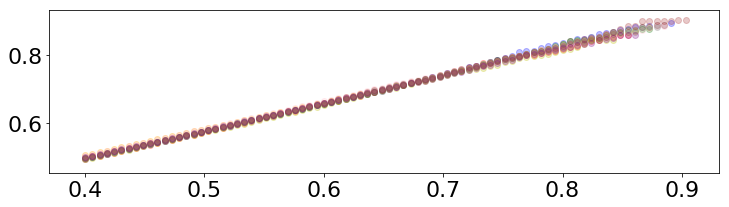

In [3374]:
col=['r','b','orange','g','pink','y','gray','brown','purple']
for c in range(nchannels):
    x=[];y=[];
    for threshold in np.linspace(.4,1,100):
        plt.scatter(threshold,np.nanmean(reliability_per_vox[c,reliability_per_vox[c,:]>threshold]),color=col[c],alpha=.25)

# Extract BOLD from Single Trials (within ROIs)

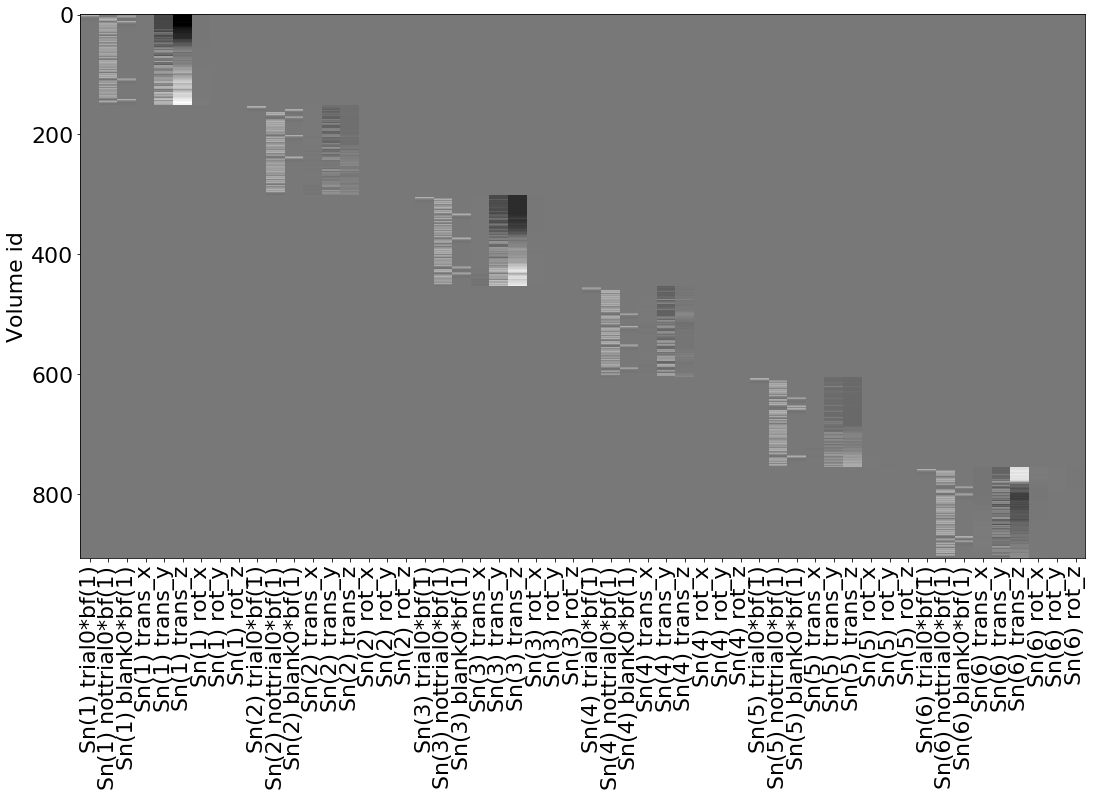

In [1316]:
spmmat = loadmat('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_encoder_wf/_subject_id_101/_trial_0/level1estimate/SPM.mat',
              struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

names = names[:-6]
designMatrix=designMatrix[:,:-6]

# plot design matrix
fig, ax = plt.subplots(figsize=(18, 10))
plt.imshow(designMatrix, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

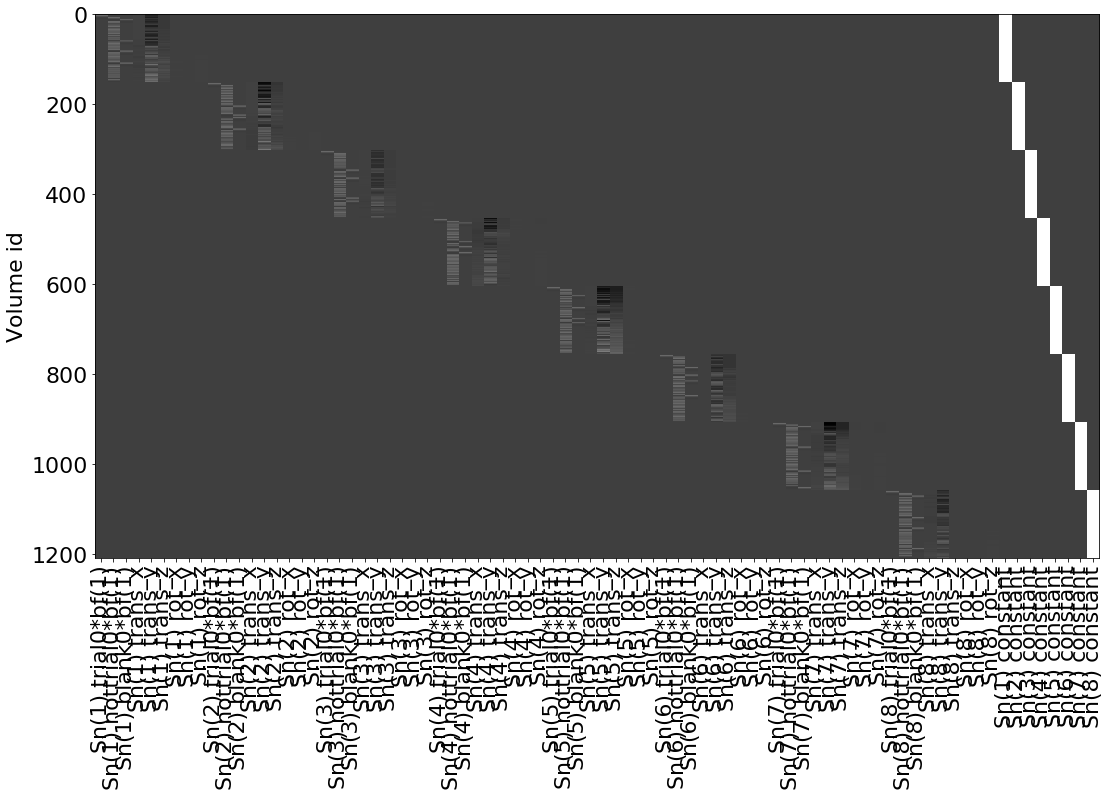

In [1315]:
spmmat = loadmat('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_0/level1estimate/SPM.mat',
              struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

#names = names[:-8]
#designMatrix=designMatrix[:,:-8]

# plot design matrix
fig, ax = plt.subplots(figsize=(18, 10))
plt.imshow(designMatrix, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

In [ ]:
spmmat = loadmat('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/nipype/output/singletrial_sizejudge_wf/_subject_id_101/_trial_0/level1estimate/SPM.mat',
              struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
# plot design matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(designMatrix, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

Go to mat_dir > dobetaseries.m
### DoBetaSeries

In [1786]:
def DoBetaSeries_encoder(subject_id,base_dir,matlab_dir,out_dir):
    import numpy as np
    import pandas as pd
    import nibabel as nib
    from scipy.io import loadmat

    num_runs = 6
    num_trials = 40
    conds = np.arange(9)
    mat = loadmat(matlab_dir + '/Color_Encoder_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]
    raw_trial_number = -1
    mydata = None
    roi = 'whole_brain'
    
    for run in range(num_runs):
        for trial in range(num_trials):
            raw_trial_number = raw_trial_number + 1

            spmmat = loadmat(out_dir + '/singletrial_encoder_wf/_subject_id_{}/_trial_{}/level1estimate/SPM.mat'.format(subject_id,trial),
                            struct_as_record=False)
            
            names = np.array([i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]])

            cond = mat['imgcolor'][run,trial]

            for n_idx in range(len(names)):
                if (names[n_idx] == "Sn({}) trial{}*bf(1)".format(run+1,trial)):
                    beta_idx = n_idx+1
            if beta_idx < 10:
                img = nib.load(out_dir+'/singletrial_encoder_wf/_subject_id_{}/_trial_{}/level1estimate/beta_000{}.nii'.format(subject_id,trial,beta_idx))
            else:
                img = nib.load(out_dir+'/singletrial_encoder_wf/_subject_id_{}/_trial_{}/level1estimate/beta_00{}.nii'.format(subject_id,trial,beta_idx))

            betas = img.get_data()
            
            for n_idx in range(len(names)):
                if (names[n_idx] == "Sn({}) blank{}*bf(1)".format(run+1,trial)):
                    blank_beta_idx = n_idx+1
            if blank_beta_idx < 10:
                img = nib.load(out_dir+'/singletrial_encoder_wf/_subject_id_{}/_trial_{}/level1estimate/beta_000{}.nii'.format(subject_id,trial,blank_beta_idx))
            else:
                img = nib.load(out_dir+'/singletrial_encoder_wf/_subject_id_{}/_trial_{}/level1estimate/beta_00{}.nii'.format(subject_id,trial,blank_beta_idx))

            if mydata == None:
                print('creating mydata variable...')
                mydata = {
                    "trial":[],
                    "run":[],
                    "cond":[],
                    "activ":[],
                    "betas":np.full((betas.shape[0],betas.shape[1],betas.shape[2],num_runs*num_trials),np.nan),
                    "blank_betas":np.full((betas.shape[0],betas.shape[1],betas.shape[2],num_runs*num_trials),np.nan),
                    "affine": img.affine,
                }
                print(mydata['betas'].shape)

            mydata['trial'].append(trial)
            mydata['run'].append(run)
            mydata['cond'].append(cond)
            mydata['betas'][:,:,:,raw_trial_number] = betas
            mydata['blank_betas'][:,:,:,raw_trial_number] = betas
    print('subj: {}, roi: {}, number of voxels: {}'.format(subject_id,roi,betas.shape))
    np.save(out_dir + '/singletrial_encoder_wf/_subject_id_{}/{}'.format(subject_id,roi),mydata)

In [1787]:
def DoBetaSeries_sizejudge(subject_id,base_dir,matlab_dir,out_dir):
    import numpy as np
    import pandas as pd
    import nibabel as nib
    from scipy.io import loadmat

    num_runs = 8
    num_trials = 40
    conds = np.arange(9)
    mat = loadmat(matlab_dir + '/Size_Judgment_scripts_s' + subject_id + '.mat') # [0,run], [0,block], [0,trial]
    trial_type = mat['trial_type_list'] # trial_type[0,run][0,trial]
    raw_trial_number = -1
    mydata = None
    roi = 'whole_brain'
    
    for run in range(num_runs):
        for trial in range(num_trials):
            raw_trial_number = raw_trial_number + 1

            spmmat = loadmat(out_dir + '/singletrial_sizejudge_wf/_subject_id_{}/_trial_{}/level1estimate/SPM.mat'.format(subject_id,trial),
                            struct_as_record=False)
            
            names = np.array([i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]])

            cond = mat['imgcolor'][run,trial]

            for n_idx in range(len(names)):
                if (names[n_idx] == "Sn({}) trial{}*bf(1)".format(run+1,trial)):
                    beta_idx = n_idx+1
            if beta_idx < 10:
                img = nib.load(out_dir+'/singletrial_sizejudge_wf/_subject_id_{}/_trial_{}/level1estimate/beta_000{}.nii'.format(subject_id,trial,beta_idx))
            else:
                img = nib.load(out_dir+'/singletrial_sizejudge_wf/_subject_id_{}/_trial_{}/level1estimate/beta_00{}.nii'.format(subject_id,trial,beta_idx))

            betas = img.get_data()
            
            for n_idx in range(len(names)):
                if (names[n_idx] == "Sn({}) blank{}*bf(1)".format(run+1,trial)):
                    blank_beta_idx = n_idx+1
            if blank_beta_idx < 10:
                img = nib.load(out_dir+'/singletrial_sizejudge_wf/_subject_id_{}/_trial_{}/level1estimate/beta_000{}.nii'.format(subject_id,trial,blank_beta_idx))
            else:
                img = nib.load(out_dir+'/singletrial_sizejudge_wf/_subject_id_{}/_trial_{}/level1estimate/beta_00{}.nii'.format(subject_id,trial,blank_beta_idx))

            if mydata == None:
                print('creating mydata variable...')
                mydata = {
                    "trial":[],
                    "run":[],
                    "cond":[],
                    "activ":[],
                    "betas":np.full((betas.shape[0],betas.shape[1],betas.shape[2],num_runs*num_trials),np.nan),
                    "blank_betas":np.full((betas.shape[0],betas.shape[1],betas.shape[2],num_runs*num_trials),np.nan),
                    "affine": img.affine,
                }
                print(mydata['betas'].shape)

            mydata['trial'].append(trial)
            mydata['run'].append(run)
            mydata['cond'].append(cond)
            mydata['betas'][:,:,:,raw_trial_number] = betas
            mydata['blank_betas'][:,:,:,raw_trial_number] = betas
    print('subj: {}, roi: {}, number of voxels: {}'.format(subject_id,roi,betas.shape))
    np.save(out_dir + '/singletrial_sizejudge_wf/_subject_id_{}/{}'.format(subject_id,roi),mydata)

In [1788]:
getbetas = Function(input_names=['subject_id','base_dir','matlab_dir','out_dir'],
                               function=DoBetaSeries_encoder)
getbetas.inputs.base_dir=base_dir
getbetas.inputs.matlab_dir=matlab_dir
getbetas.inputs.out_dir=out_dir
subjects = ['101','102','103']

for subject_id in subjects:
    getbetas.inputs.subject_id = subject_id
    getbetas.run()

creating mydata variable...
(77, 82, 74, 240)
subj: 101, roi: whole_brain, number of voxels: (77, 82, 74)
creating mydata variable...
(71, 87, 69, 240)
subj: 102, roi: whole_brain, number of voxels: (71, 87, 69)
creating mydata variable...
(68, 89, 69, 240)
subj: 103, roi: whole_brain, number of voxels: (68, 89, 69)


In [1789]:
getbetas = Function(input_names=['subject_id','base_dir','matlab_dir','out_dir'],
                               function=DoBetaSeries_sizejudge)
getbetas.inputs.base_dir=base_dir
getbetas.inputs.matlab_dir=matlab_dir
getbetas.inputs.out_dir=out_dir
subjects = ['101','102','103']

for subject_id in subjects:
    getbetas.inputs.subject_id = subject_id
    getbetas.run()

creating mydata variable...
(77, 82, 74, 320)
subj: 101, roi: whole_brain, number of voxels: (77, 82, 74)
creating mydata variable...
(71, 87, 69, 320)
subj: 102, roi: whole_brain, number of voxels: (71, 87, 69)
creating mydata variable...
(68, 89, 69, 320)
subj: 103, roi: whole_brain, number of voxels: (68, 89, 69)


# Inverted Encoding Model
## Setup

In [2203]:
# load convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(y):
    x = deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

def make_vonmises(xx,mu,sd,amp=np.ones(nchannels)/nchannels):
    try:
        try:
            len(amp)
        except:
            amp = np.array([amp])
        res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
        res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
        if np.all(res==0):
            res[int(np.floor(mu))] = amp[0]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        return norm_res * amp[0]
    except: # if making multiple tuning functions at once
        res1 = np.full( (360,len(mu)) , np.nan)
        for i in range(len(mu)):
            res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
            res[np.isnan(res)] = 0 
            if np.all(res==0):
                res[int(np.floor(mu[i]))] = amp[i]
            norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
            res1[:,i] = norm_res * amp[i]
        return res1
    
cosd = lambda x : np.cos( np.deg2rad(x) )
make_basis_function = lambda xx,mu : np.power( (cosd(xx/2-mu/2) ), ( nchannels - (nchannels % 2) ) )

## Load data

In [4250]:
subject_id = '103'
raw_ntrials = 240
vox_exclude = False 
mydata = np.load(out_dir + '/singletrial_encoder_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

rois = ['lh.V1v','lh.V1d','lh.V2v','lh.V2d','lh.V3v','lh.V3d',
         'lh.V4v','lh.V3ab','lh.V7',
         'rh.V1v','rh.V1d','rh.V2v','rh.V2d','rh.V3v','rh.V3d',
         'rh.V4v','rh.V3ab','rh.V7',
        'lh.colorROI','rh.colorROI']
#rois = ['lh.V1v','lh.V1d','rh.V1v','rh.V1d']
rois = ['lh.V4v','rh.V4v']
rois = ['lh.colorROI','rh.colorROI']
#rois = ['lh.V4v','rh.V4v','lh.colorROI','rh.colorROI']
mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + rois[0] + '.npy')

for roi in rois[1:]:
    new_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + roi + '.npy')
    mask = np.concatenate((mask, new_mask), axis=0)
mask = np.unique(mask,axis=0) # only keep unique voxels
print("number of voxels from (combined) rois: {}".format(mask.shape[0]))

if vox_exclude:
    reliability_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/reliability_90' + '.npy')
    for idx in range(mask.shape[0]):
        if ~np.any(np.sum(reliability_mask == mask[idx,:],axis=1) == 3):
            mask[idx,:] = [np.nan,np.nan,np.nan]
    mask = mask[~np.isnan(mask).any(axis=1)]
    print("number of voxels after reliability_mask exclusion: {}".format(mask.shape[0]))

#func_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'encoder_all_v_blank' + '.npy')
#for idx in range(mask.shape[0]):
#    if ~np.any(np.sum(func_mask == mask[idx,:],axis=1) == 3):
#        mask[idx,:] = [np.nan,np.nan,np.nan]
#mask = mask[~np.isnan(mask).any(axis=1)]
#print("number of voxels after func_mask exclusion: {}".format(mask.shape[0]))

#func_mask2 = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'sizejudge_all_v_blank' + '.npy')
#for idx in range(mask.shape[0]):
#    if ~np.any(np.sum(func_mask2 == mask[idx,:],axis=1) == 3):
#        mask[idx,:] = [np.nan,np.nan,np.nan]
#mask = mask[~np.isnan(mask).any(axis=1)]
#print("number of voxels after func_mask2 exclusion: {}".format(mask.shape[0]))
    
#mybetas = np.full((raw_ntrials,np.sum(~np.isnan(mydata['betas'][map(int,mask[:,0]),map(int,mask[:,1]),map(int,mask[:,2]),0].flatten()))),np.nan)
mybetas = np.full((raw_ntrials,mask.shape[0]),np.nan)
for t in range(raw_ntrials):
    betas = mydata['betas'][:,:,:,t]
    betas = betas[map(int,mask[:,0]),map(int,mask[:,1]),map(int,mask[:,2])]
    #mybetas[t,:] = betas[~np.isnan(betas)].flatten()
    mybetas[t,:] = betas.flatten()

boolean_nan = ~np.isnan(mydata['cond'])
trial_features = mydata['cond']
trial_by_vox = mybetas[boolean_nan,:]

trial_features = [trial_features[i] for i, x in enumerate(boolean_nan) if x]
trial_features = np.array(map(int,trial_features))
ntrials = len(trial_features)
nchannels = 9

print('Number of (non-NaN) trials: {}'.format(ntrials))
print('Features: {}'.format(np.unique(trial_features)))
print('mydata keys: {}'.format(mydata.keys()))
print('trial_by_vox shape: {}'.format(trial_by_vox.shape))
print('Number of voxels: {}'.format(trial_by_vox.shape[1]))

number of voxels from (combined) rois: 6868
Number of (non-NaN) trials: 216
Features: [  0  40  80 120 160 200 240 280 320]
mydata keys: ['run', 'blank_betas', 'affine', 'activ', 'trial', 'cond', 'betas']
trial_by_vox shape: (216, 6868)
Number of voxels: 6868


## Setup IEM

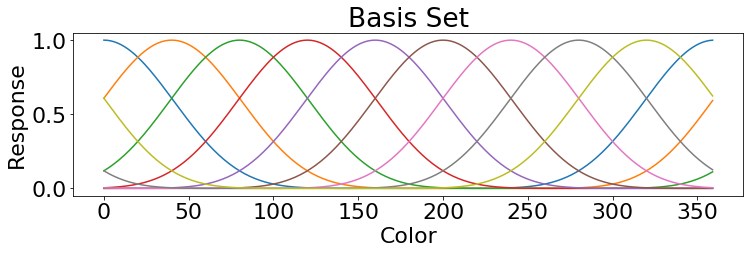

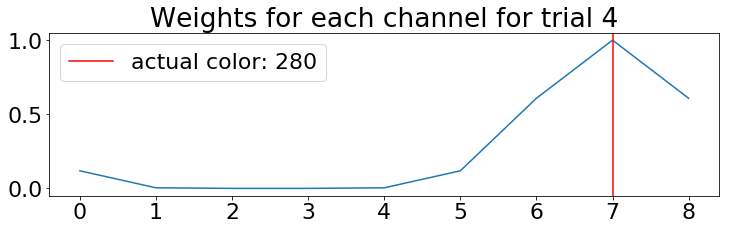

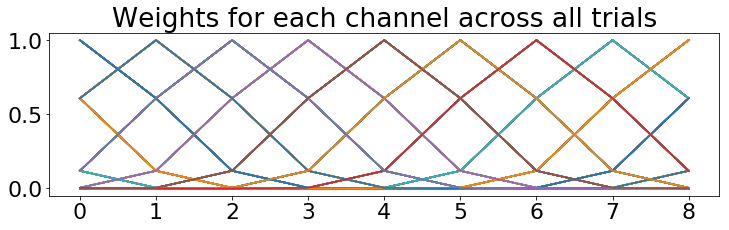

In [4251]:
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

nchannels = 9
channel_sd = np.ones(nchannels)*40 # standard deviation of each basis
basis_points = np.linspace(0,360-(360//nchannels),nchannels) # basis set centers
basis_points = list(map(int, basis_points))
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)
    
# create each basis channel
basis_set = np.full((360,nchannels),np.nan)
for c in range(nchannels):
    basis_set[:,c] = make_basis_function(feature_space, basis_points[c])

basis_set2 = make_vonmises(feature_space, basis_points, channel_sd)

# plot basis functions
for chan in range(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Basis Set")
plt.show()

trial_weights = basis_set[trial_features,:]

trial = 3
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [4252]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 9


## Attain and assess reconstructions

replacing NaN voxels with avg betas


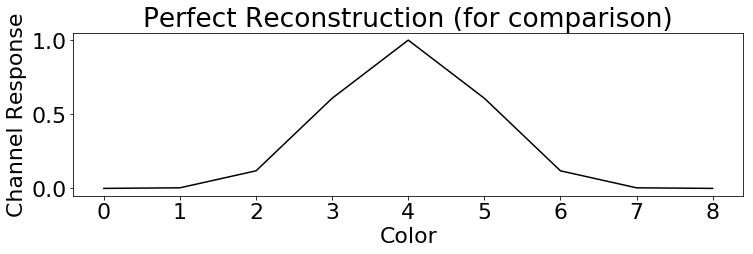

Reconstructions aligned at 4 

train: avg MAE: 0.503113293564


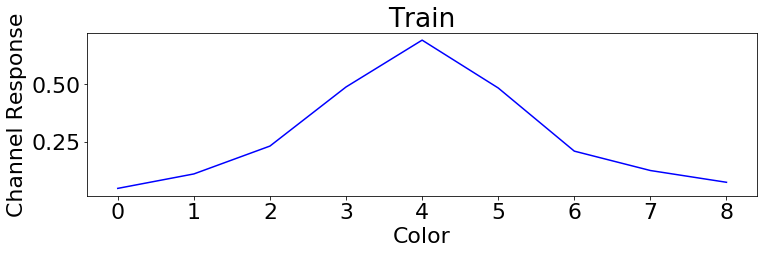

test: avg MAE: 0.792309689051


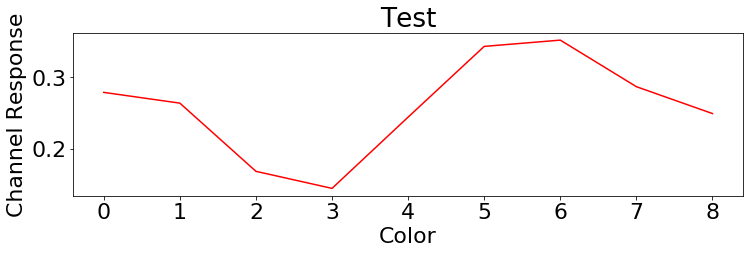

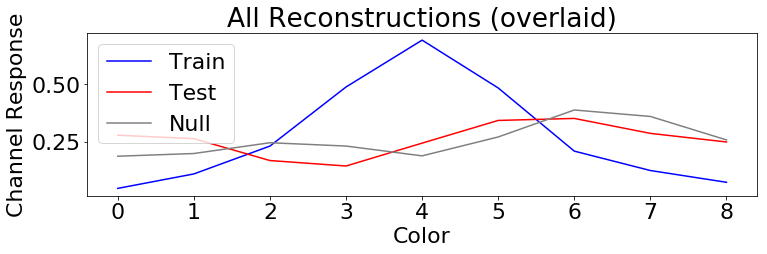

null: avg MAE: 0.725564356232


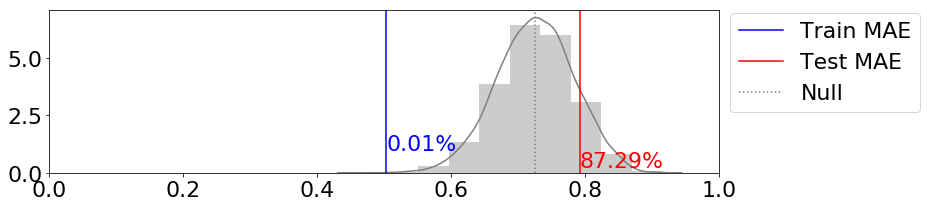

% overlap w/ null distribution (10000 permutations): 87.29%
basically, this means p=0.873
meaning that test reconstructions are not significantly different from null reconstructions.


In [4253]:
## Cross-validation ##

# prep cross-validation, assign trials as training or test data
n_splits = 6 # leave-one-run-out
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X);

cv_iter = -1
for train_index, test_index in kf.split(X):
    if cv_iter == -1:
        cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
        cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        saved_weights = np.full((n_splits,nchannels,trial_by_vox.shape[1]),np.nan)
    cv_iter = cv_iter+1

    if len(trial_by_vox[np.isnan(trial_by_vox)]) > 0:
        trial_by_vox[np.isnan(trial_by_vox)] = np.nanmean(trial_by_vox)
        print("replacing NaN voxels with avg betas")
    trn = trial_by_vox[train_index,:]
    tst = trial_by_vox[test_index,:]

    trnf = trial_features[train_index]
    tstf = trial_features[test_index]
    trn_or_tst = np.zeros(len(trial_features))
    trn_or_tst[test_index] = 1

    saved_weights[cv_iter,:] = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , trn.T, rcond=None)[0].T
    cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , tst.T, rcond=None)[0].T

# average folds
cr_trn = np.mean(cr_trn[:,:,:],axis=0)
cr_tst = np.mean(cr_tst[:,:,:],axis=0)
saved_weights = np.mean(saved_weights[:,:,:],axis=0)
full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

# Plot perfect reconstruction for comparison
perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]
plt.plot(perfect_recon,color='k')
plt.title("Perfect Reconstruction (for comparison)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (training)
cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
print("Reconstructions aligned at {} \n".format(shiftby))
trial_actual = np.full(cr_trn.shape[0],999)
trial_guess = np.full(cr_trn.shape[0],999)
for trial in np.arange(cr_trn.shape[0]):
    trial_actual[trial] = int(trnf[trial]/(360/nchannels))
    trial_guess[trial] = np.argmax(cr_trn[trial,:])
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
trial_diff = np.abs(trial_actual-trial_guess)
trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
#trial_diff[trial_diff>2] = 2
trn_mae = np.mean(trial_diff)
print("train: avg MAE: {}".format(trn_mae))
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b')
plt.title("Train")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (testing)
cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
for trial in np.arange(cr_tst.shape[0]):
    trial_actual[trial] = int(tstf[trial]/(360/nchannels))
    trial_guess[trial] = np.argmax(cr_tst[trial,:])
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
trial_diff = np.abs(trial_actual-trial_guess)
trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
#trial_diff[trial_diff>2] = 2
tst_mae = np.mean(trial_diff)
print("test: avg MAE: {}".format(tst_mae))
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r')
plt.title("Test")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Null distribution testing
numperms = 10000
cr_center_null = np.empty_like(cr_tst)
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
null_mae = np.full(numperms,np.nan)
for perm in np.arange(numperms):
    tstf_shuffle = np.random.permutation(tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
    null_mae[perm] = np.mean(trial_diff)
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
plt.title("All Reconstructions (overlaid)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend()
plt.show()

print("null: avg MAE: {}".format(np.mean(null_mae)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

sns.distplot(null_mae,color='gray',bins=10)
plt.axvline(trn_mae,color='blue',label="Train MAE")
plt.axvline(tst_mae,color='red',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
plt.xlim([0,1])
plt.show()

print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
print("basically, this means p={:.3f}".format(tst_overlap/100))
if tst_overlap < 5:
    print("meaning that test reconstructions significantly different from null reconstructions!")
else:
    print("meaning that test reconstructions are not significantly different from null reconstructions.")

## new method

replacing NaN voxels with avg betas


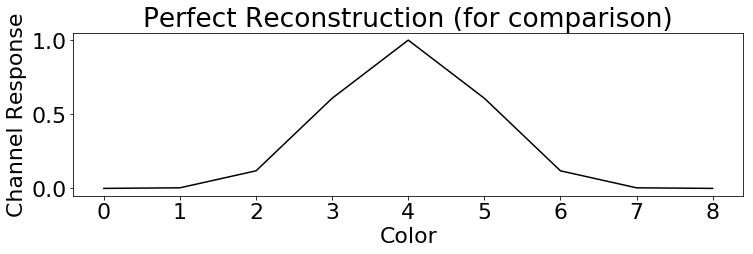

Reconstructions aligned at 4 

train: avg MAE: 0.509651495527


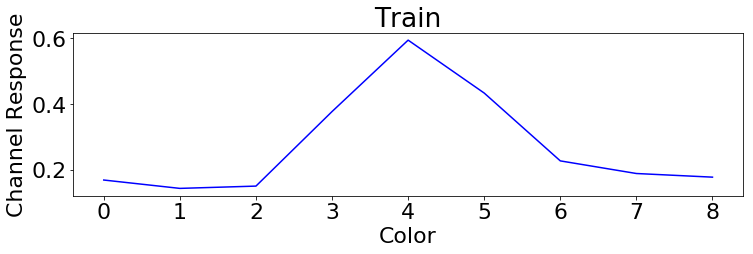

test: avg MAE: 0.646882033042


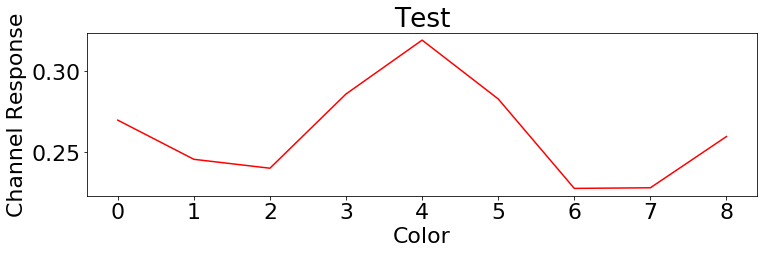

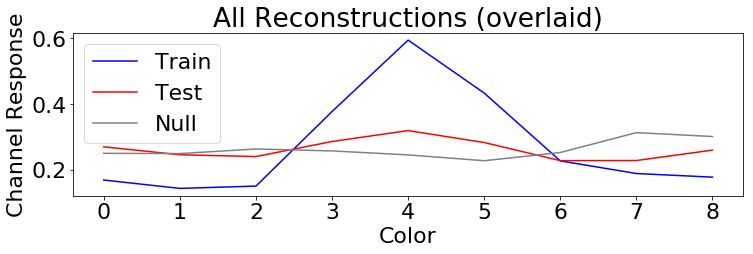

null: avg MAE: 0.727246673471


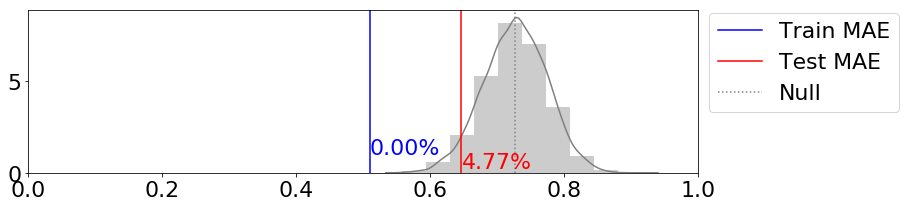

% overlap w/ null distribution (10000 permutations): 4.77%
basically, this means p=0.048
meaning that test reconstructions significantly different from null reconstructions!


In [4227]:
## Cross-validation ##

# prep cross-validation, assign trials as training or test data
n_splits = 6 # leave-one-run-out
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X);

cv_iter = -1
for train_index, test_index in kf.split(X):
    if cv_iter == -1:
        cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
        cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        saved_weights = np.full((n_splits,nchannels,trial_by_vox.shape[1]),np.nan)
    cv_iter = cv_iter+1

    if len(trial_by_vox[np.isnan(trial_by_vox)]) > 0:
        trial_by_vox[np.isnan(trial_by_vox)] = np.nanmean(trial_by_vox)
        print("replacing NaN voxels with avg betas")
    trn = trial_by_vox[train_index,:]
    tst = trial_by_vox[test_index,:]

    trnf = trial_features[train_index]
    tstf = trial_features[test_index]
    trn_or_tst = np.zeros(len(trial_features))
    trn_or_tst[test_index] = 1

    saved_weights[cv_iter,:] = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , trn.T, rcond=None)[0].T
    cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , tst.T, rcond=None)[0].T

# average folds
cr_trn = np.mean(cr_trn[:,:,:],axis=0)
cr_tst = np.mean(cr_tst[:,:,:],axis=0)
saved_weights = np.mean(saved_weights[:,:,:],axis=0)
full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

# Plot perfect reconstruction for comparison
perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]
plt.plot(perfect_recon,color='k')
plt.title("Perfect Reconstruction (for comparison)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (training)
cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
print("Reconstructions aligned at {} \n".format(shiftby))
trial_actual = np.full(cr_trn.shape[0],999)
trial_guess = np.full((cr_trn.shape[0],nchannels//2),999)
for trial in np.arange(cr_trn.shape[0]):
    trial_actual[trial] = int(trnf[trial]/(360/nchannels))
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    for c in range(nchannels//2):
        trial_guess[trial,c] = np.argsort(-cr_trn[trial,:])[c]
trial_diff = np.full((cr_trn.shape[0],nchannels//2),np.nan)
trn_mae = np.full(nchannels//2,np.nan)
for c in range(nchannels//2):
    trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
    trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
    trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
    trn_mae[c] = np.mean(trial_diff[:,c])
weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
trn_mae = np.average(trn_mae,weights=weights)
print("train: avg MAE: {}".format(trn_mae))
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b')
plt.title("Train")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (testing)
cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full((cr_tst.shape[0],nchannels//2),999)
for trial in np.arange(cr_tst.shape[0]):
    trial_actual[trial] = int(tstf[trial]/(360/nchannels))
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    for c in range(nchannels//2):
        trial_guess[trial,c] = np.argsort(-cr_tst[trial,:])[c]
trial_diff = np.full((cr_tst.shape[0],nchannels//2),np.nan)
tst_mae = np.full(nchannels//2,np.nan)
for c in range(nchannels//2):
    trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
    trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
    trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
    tst_mae[c] = np.mean(trial_diff[:,c])
weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
tst_mae = np.average(tst_mae,weights=weights)
print("test: avg MAE: {}".format(tst_mae))
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r')
plt.title("Test")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Null distribution testing
numperms = 10000
cr_center_null = np.empty_like(cr_tst)
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full((cr_tst.shape[0],nchannels//2),999)
null_mae = np.full(numperms,np.nan)
for perm in np.arange(numperms):
    tstf_shuffle = np.random.permutation(tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
        cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        for c in range(nchannels//2):
            trial_guess[trial,c] = np.argsort(-cr_tst[trial,:])[c]
    trial_diff = np.full((cr_tst.shape[0],nchannels//2),np.nan)
    null_mae0 = np.full(nchannels//2,np.nan)
    for c in range(nchannels//2):
        trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
        trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
        trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
        null_mae0[c] = np.mean(trial_diff[:,c])
    weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
    null_mae[perm] = np.average(null_mae0,weights=weights)
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
plt.title("All Reconstructions (overlaid)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend()
plt.show()

print("null: avg MAE: {}".format(np.mean(null_mae)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

sns.distplot(null_mae,color='gray',bins=10)
plt.axvline(trn_mae,color='blue',label="Train MAE")
plt.axvline(tst_mae,color='red',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
plt.xlim([0,1])
plt.show()

print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
print("basically, this means p={:.3f}".format(tst_overlap/100))
if tst_overlap < 5:
    print("meaning that test reconstructions significantly different from null reconstructions!")
else:
    print("meaning that test reconstructions are not significantly different from null reconstructions.")

# IEM: SizeJudge

## Load data
### Whole brain (reliability voxels)

In [3317]:
subject_id = '101'
raw_ntrials = 320
mydata = np.load(out_dir + '/singletrial_sizejudge_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

reliability_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/reliability' + '.npy')
print("number of voxels from (combined) rois: {}".format(reliability_mask.shape[0]))
    
mybetas = np.full((raw_ntrials,reliability_mask.shape[0]),np.nan)
for t in range(raw_ntrials):
    betas = mydata['betas'][:,:,:,t]
    betas = betas[map(int,reliability_mask[:,0]),map(int,reliability_mask[:,1]),map(int,reliability_mask[:,2])]
    #mybetas[t,:] = betas[~np.isnan(betas)].flatten()
    mybetas[t,:] = betas.flatten()

boolean_nan = ~np.isnan(mydata['cond'])
trial_features = mydata['cond']
trial_by_vox = mybetas[boolean_nan,:]

trial_features = [trial_features[i] for i, x in enumerate(boolean_nan) if x]
trial_features = np.array(map(int,trial_features))
ntrials = len(trial_features)
nchannels = 9

print('Number of (non-NaN) trials: {}'.format(ntrials))
print('Features: {}'.format(np.unique(trial_features)))
print('mydata keys: {}'.format(mydata.keys()))
print('trial_by_vox shape: {}'.format(trial_by_vox.shape))
print('Number of voxels: {}'.format(trial_by_vox.shape[1]))

number of voxels from (combined) rois: 56710
Number of (non-NaN) trials: 288
Features: [  1   2   3   4   5   6   7   8  10  31  32  34  35  36  38  39  40  41
  42  44  45  46  48  49  50  71  72  73  74  75  76  77  78  80  81  82
  84  85  86  87  88  89  90 111 112 113 115 116 117 118 119 120 121 122
 123 124 125 126 129 130 151 152 153 154 155 156 157 158 160 161 162 163
 164 165 167 168 191 192 194 195 196 200 201 202 204 205 206 207 209 210
 231 232 233 236 238 239 240 241 242 244 245 246 247 248 249 250 272 273
 274 275 276 277 278 281 282 283 284 285 287 289 290 311 312 313 315 316
 317 319 320 321 322 323 324 325 327 329 330 351 352 353 354 355 356 359]
mydata keys: ['run', 'blank_betas', 'affine', 'activ', 'trial', 'cond', 'betas']
trial_by_vox shape: (288, 56710)
Number of voxels: 56710


### ROIs (reliability voxels)

In [4239]:
subject_id = '103'
raw_ntrials = 320
vox_exclude = False 
mydata = np.load(out_dir + '/singletrial_sizejudge_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

rois = ['lh.V1v','lh.V1d','lh.V2v','lh.V2d','lh.V3v','lh.V3d',
         'lh.V4v','lh.V3ab','lh.V7',
         'rh.V1v','rh.V1d','rh.V2v','rh.V2d','rh.V3v','rh.V3d',
         'rh.V4v','rh.V3ab','rh.V7',
        'lh.colorROI','rh.colorROI']
rois = ['lh.V1v','lh.V1d','rh.V1v','rh.V1d']
#rois = ['lh.V4v','rh.V4v']
rois = ['lh.colorROI','rh.colorROI']
#rois = ['lh.V4v','rh.V4v','lh.colorROI','rh.colorROI']
mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + rois[0] + '.npy')

for roi in rois[1:]:
    new_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + roi + '.npy')
    mask = np.concatenate((mask, new_mask), axis=0)
mask = np.unique(mask,axis=0) # only keep unique voxels
print("number of voxels from (combined) rois: {}".format(mask.shape[0]))

if vox_exclude:
    reliability_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/reliability_90' + '.npy')
    for idx in range(mask.shape[0]):
        if ~np.any(np.sum(reliability_mask == mask[idx,:],axis=1) == 3):
            mask[idx,:] = [np.nan,np.nan,np.nan]
    mask = mask[~np.isnan(mask).any(axis=1)]
    print("number of voxels after reliability_mask exclusion: {}".format(mask.shape[0]))

#func_mask = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'encoder_all_v_blank' + '.npy')
#for idx in range(mask.shape[0]):
#    if ~np.any(np.sum(func_mask == mask[idx,:],axis=1) == 3):
#        mask[idx,:] = [np.nan,np.nan,np.nan]
#mask = mask[~np.isnan(mask).any(axis=1)]
#print("number of voxels after func_mask exclusion: {}".format(mask.shape[0]))

#func_mask2 = np.load(base_dir + '/sub-' + subject_id + '/retmaps/' + 'sizejudge_all_v_blank' + '.npy')
#for idx in range(mask.shape[0]):
#    if ~np.any(np.sum(func_mask2 == mask[idx,:],axis=1) == 3):
#        mask[idx,:] = [np.nan,np.nan,np.nan]
#mask = mask[~np.isnan(mask).any(axis=1)]
#print("number of voxels after func_mask2 exclusion: {}".format(mask.shape[0]))
    
#mybetas = np.full((raw_ntrials,np.sum(~np.isnan(mydata['betas'][map(int,mask[:,0]),map(int,mask[:,1]),map(int,mask[:,2]),0].flatten()))),np.nan)
mybetas = np.full((raw_ntrials,mask.shape[0]),np.nan)
for t in range(raw_ntrials):
    betas = mydata['betas'][:,:,:,t]
    betas = betas[map(int,mask[:,0]),map(int,mask[:,1]),map(int,mask[:,2])]
    #mybetas[t,:] = betas[~np.isnan(betas)].flatten()
    mybetas[t,:] = betas.flatten()

boolean_nan = ~np.isnan(mydata['cond'])
trial_features = mydata['cond']
trial_by_vox = mybetas[boolean_nan,:]

trial_features = [trial_features[i] for i, x in enumerate(boolean_nan) if x]
trial_features = np.array(map(int,trial_features))
ntrials = len(trial_features)
nchannels = 9

print('Number of (non-NaN) trials: {}'.format(ntrials))
print('Features: {}'.format(np.unique(trial_features)))
print('mydata keys: {}'.format(mydata.keys()))
print('trial_by_vox shape: {}'.format(trial_by_vox.shape))
print('Number of voxels: {}'.format(trial_by_vox.shape[1]))

number of voxels from (combined) rois: 6868
Number of (non-NaN) trials: 288
Features: [  3   4   5   6   7   8   9  10  31  33  34  35  37  38  39  40  41  42
  43  44  45  48  49  50  72  73  74  77  78  79  80  82  83  84  85  86
  88  89  90 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127
 129 151 154 155 156 159 160 161 162 163 165 166 167 168 170 191 192 193
 194 195 197 198 199 200 201 202 203 204 207 209 210 231 232 233 236 237
 238 239 240 241 243 244 245 246 247 248 249 250 272 273 274 275 276 277
 278 279 282 283 284 285 286 287 289 290 312 315 316 317 318 319 320 321
 322 323 324 325 326 327 329 330 351 352 353 354 355 358 359 360]
mydata keys: ['run', 'blank_betas', 'affine', 'activ', 'trial', 'cond', 'betas']
trial_by_vox shape: (288, 6868)
Number of voxels: 6868


## setup IEM

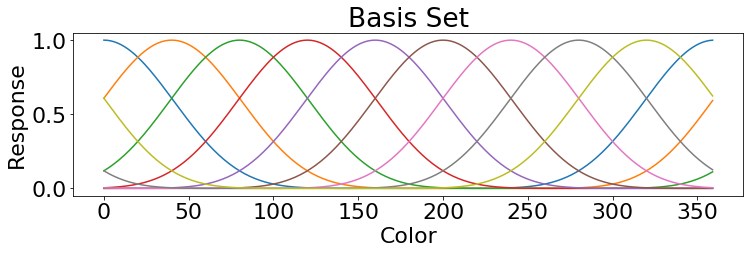

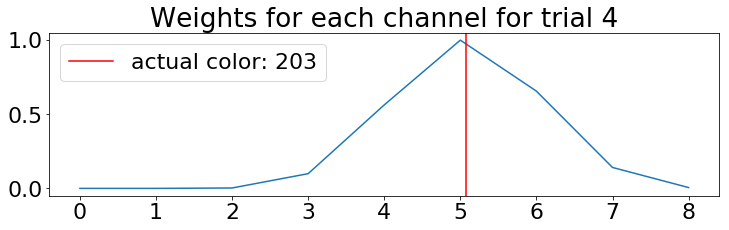

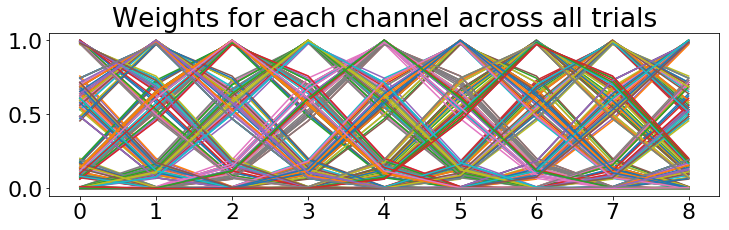

In [4240]:
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

nchannels = 9
channel_sd = np.ones(nchannels)*40 # standard deviation of each basis
basis_points = np.linspace(0,360-(360//nchannels),nchannels) # basis set centers
basis_points = list(map(int, basis_points))
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)
    
# create each basis channel
basis_set = np.full((360,nchannels),np.nan)
for c in range(nchannels):
    basis_set[:,c] = make_basis_function(feature_space, basis_points[c])

basis_set2 = make_vonmises(feature_space, basis_points, channel_sd)

# plot basis functions
for chan in range(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Basis Set")
plt.show()

trial_weights = basis_set[within360(trial_features),:]

trial = 3
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [ ]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

## Attain and assess reconstructions

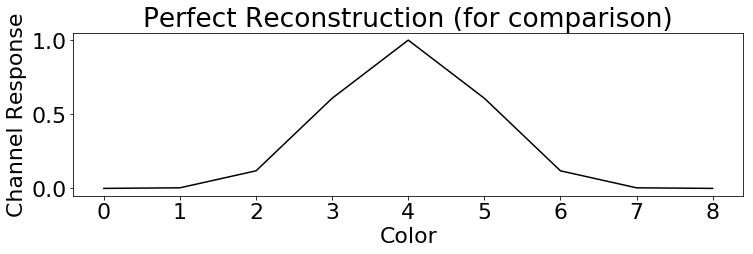

Reconstructions aligned at 4 

train: avg MAE: 0.593141498451


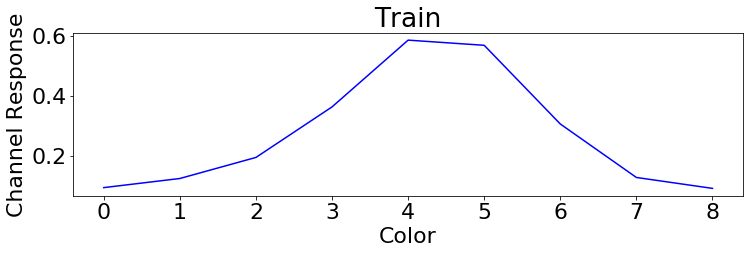

test: avg MAE: 0.627255872942


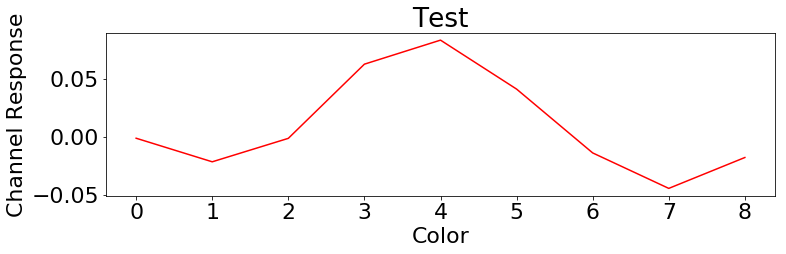

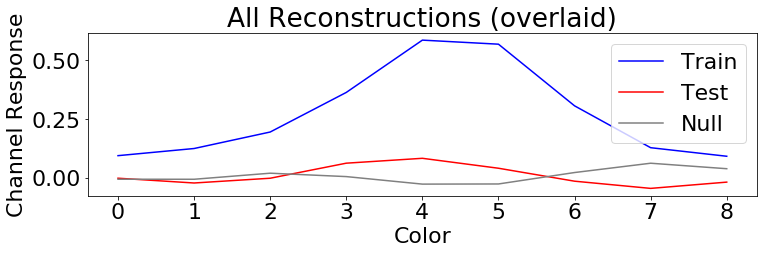

null: avg MAE: 0.71990954583


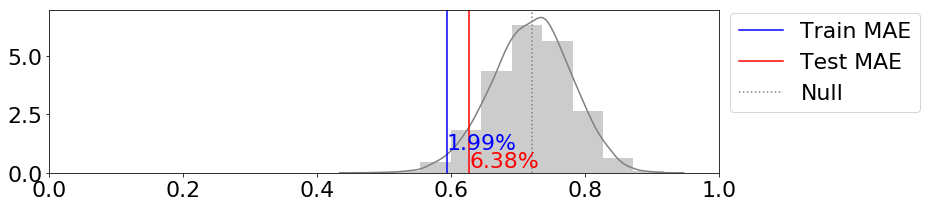

% overlap w/ null distribution (10000 permutations): 6.38%
basically, this means p=0.064
meaning that test reconstructions are not significantly different from null reconstructions.


In [4234]:
## Cross-validation ##

# prep cross-validation, assign trials as training or test data
n_splits = 8 # leave-one-run-out
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X);

cv_iter = -1
for train_index, test_index in kf.split(X):
    if cv_iter == -1:
        cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
        cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        saved_weights = np.full((n_splits,nchannels,trial_by_vox.shape[1]),np.nan)
    cv_iter = cv_iter+1

    if len(trial_by_vox[np.isnan(trial_by_vox)]) > 0:
        trial_by_vox[np.isnan(trial_by_vox)] = np.nanmean(trial_by_vox)
        print("replacing NaN voxels with avg betas")
    trn = trial_by_vox[train_index,:]
    tst = trial_by_vox[test_index,:]

    trnf = trial_features[train_index]
    tstf = trial_features[test_index]
    trn_or_tst = np.zeros(len(trial_features))
    trn_or_tst[test_index] = 1
    
    saved_weights[cv_iter,:] = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , trn.T, rcond=None)[0].T
    cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , tst.T, rcond=None)[0].T

# average folds
cr_trn = np.mean(cr_trn[:,:,:],axis=0)
cr_tst = np.mean(cr_tst[:,:,:],axis=0)
saved_weights = np.mean(saved_weights[:,:,:],axis=0)

# Plot perfect reconstruction for comparison
perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]
plt.plot(perfect_recon,color='k')
plt.title("Perfect Reconstruction (for comparison)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (training)
cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
print("Reconstructions aligned at {} \n".format(shiftby))
trial_actual = np.full(cr_trn.shape[0],999)
trial_guess = np.full(cr_trn.shape[0],999)
for trial in np.arange(cr_trn.shape[0]):
    trial_actual[trial] = int(trnf[trial]/(360/nchannels))
    trial_guess[trial] = np.argmax(cr_trn[trial,:])
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
trial_diff = np.abs(trial_actual-trial_guess)
trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
#trial_diff[trial_diff>2] = 2
trn_mae = np.mean(trial_diff)
print("train: avg MAE: {}".format(trn_mae))
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b')
plt.title("Train")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (testing)
cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
for trial in np.arange(cr_tst.shape[0]):
    trial_actual[trial] = int(tstf[trial]/(360/nchannels))
    trial_guess[trial] = np.argmax(cr_tst[trial,:])
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
trial_diff = np.abs(trial_actual-trial_guess)
trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
#trial_diff[trial_diff>2] = 2
tst_mae = np.mean(trial_diff)
print("test: avg MAE: {}".format(tst_mae))
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r')
plt.title("Test")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Null distribution testing
numperms = 10000
cr_center_null = np.empty_like(cr_tst)
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
null_mae = np.full(numperms,np.nan)
for perm in np.arange(numperms):
    tstf_shuffle = np.random.permutation(tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
    #trial_diff[trial_diff>2] = 2
    null_mae[perm] = np.mean(trial_diff)
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
plt.title("All Reconstructions (overlaid)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend()
plt.show()

print("null: avg MAE: {}".format(np.mean(null_mae)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

sns.distplot(null_mae,color='gray',bins=10)
plt.axvline(trn_mae,color='blue',label="Train MAE")
plt.axvline(tst_mae,color='red',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
plt.xlim([0,1])
plt.show()

print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
print("basically, this means p={:.3f}".format(tst_overlap/100))
if tst_overlap < 5:
    print("meaning that test reconstructions significantly different from null reconstructions!")
else:
    print("meaning that test reconstructions are not significantly different from null reconstructions.")

## new method

replacing NaN voxels with avg betas


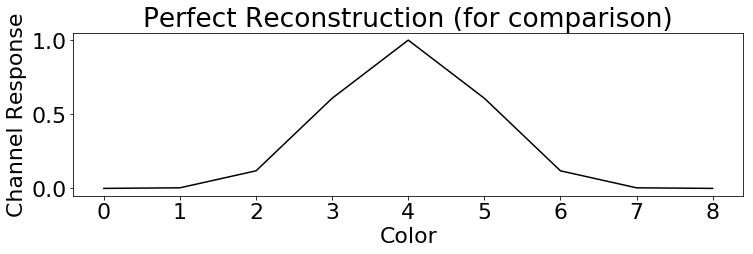

Reconstructions aligned at 4 

train: avg MAE: 0.608414373829


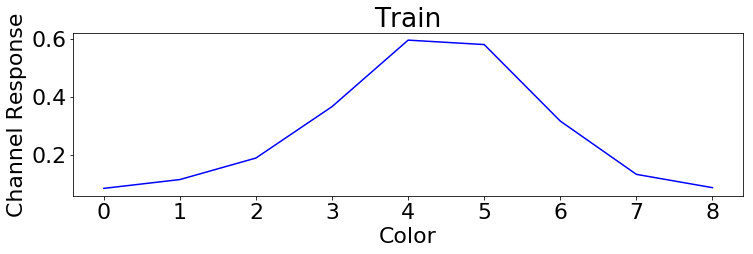

test: avg MAE: 0.689538965993


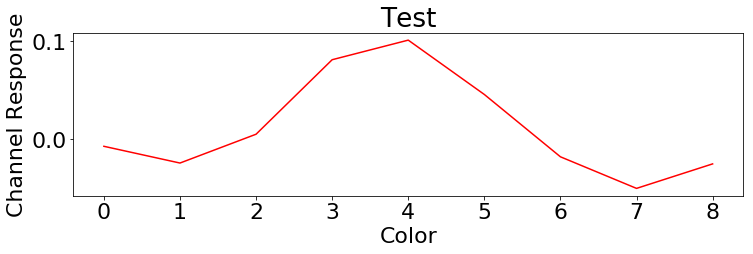

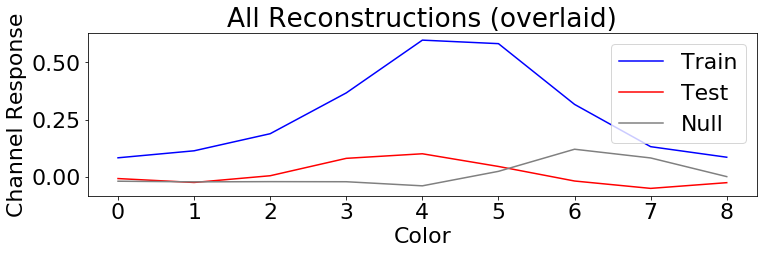

null: avg MAE: 0.725342169735


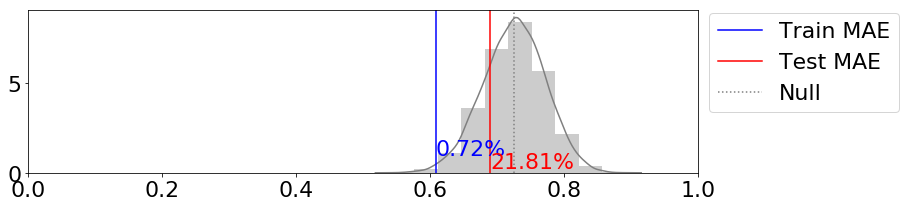

% overlap w/ null distribution (10000 permutations): 21.81%
basically, this means p=0.218
meaning that test reconstructions are not significantly different from null reconstructions.


In [4241]:
## Cross-validation ##

# prep cross-validation, assign trials as training or test data
n_splits = 8 # leave-one-run-out
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X);

cv_iter = -1
for train_index, test_index in kf.split(X):
    if cv_iter == -1:
        cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
        cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        saved_weights = np.full((n_splits,nchannels,trial_by_vox.shape[1]),np.nan)
    cv_iter = cv_iter+1

    if len(trial_by_vox[np.isnan(trial_by_vox)]) > 0:
        trial_by_vox[np.isnan(trial_by_vox)] = np.nanmean(trial_by_vox)
        print("replacing NaN voxels with avg betas")
    trn = trial_by_vox[train_index,:]
    tst = trial_by_vox[test_index,:]

    trnf = trial_features[train_index]
    tstf = trial_features[test_index]
    trn_or_tst = np.zeros(len(trial_features))
    trn_or_tst[test_index] = 1

    saved_weights[cv_iter,:] = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , trn.T, rcond=None)[0].T
    cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , tst.T, rcond=None)[0].T

# average folds
cr_trn = np.mean(cr_trn[:,:,:],axis=0)
cr_tst = np.mean(cr_tst[:,:,:],axis=0)
saved_weights = np.mean(saved_weights[:,:,:],axis=0)

# Plot perfect reconstruction for comparison
perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]
plt.plot(perfect_recon,color='k')
plt.title("Perfect Reconstruction (for comparison)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (training)
cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
print("Reconstructions aligned at {} \n".format(shiftby))
trial_actual = np.full(cr_trn.shape[0],999)
trial_guess = np.full((cr_trn.shape[0],nchannels//2),999)
for trial in np.arange(cr_trn.shape[0]):
    trial_actual[trial] = int(trnf[trial]/(360/nchannels))
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    for c in range(nchannels//2):
        trial_guess[trial,c] = np.argsort(-cr_trn[trial,:])[c]
trial_diff = np.full((cr_trn.shape[0],nchannels//2),np.nan)
trn_mae = np.full(nchannels//2,np.nan)
for c in range(nchannels//2):
    trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
    trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
    trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
    trn_mae[c] = np.mean(trial_diff[:,c])
weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
trn_mae = np.average(trn_mae,weights=weights)
print("train: avg MAE: {}".format(trn_mae))
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b')
plt.title("Train")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (testing)
cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full((cr_tst.shape[0],nchannels//2),999)
for trial in np.arange(cr_tst.shape[0]):
    trial_actual[trial] = int(tstf[trial]/(360/nchannels))
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    for c in range(nchannels//2):
        trial_guess[trial,c] = np.argsort(-cr_tst[trial,:])[c]
trial_diff = np.full((cr_tst.shape[0],nchannels//2),np.nan)
tst_mae = np.full(nchannels//2,np.nan)
for c in range(nchannels//2):
    trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
    trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
    trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
    tst_mae[c] = np.mean(trial_diff[:,c])
weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
tst_mae = np.average(tst_mae,weights=weights)
print("test: avg MAE: {}".format(tst_mae))
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r')
plt.title("Test")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Null distribution testing
numperms = 10000
cr_center_null = np.empty_like(cr_tst)
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full((cr_tst.shape[0],nchannels//2),999)
null_mae = np.full(numperms,np.nan)
for perm in np.arange(numperms):
    tstf_shuffle = np.random.permutation(tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
        cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        for c in range(nchannels//2):
            trial_guess[trial,c] = np.argsort(-cr_tst[trial,:])[c]
    trial_diff = np.full((cr_tst.shape[0],nchannels//2),np.nan)
    null_mae0 = np.full(nchannels//2,np.nan)
    for c in range(nchannels//2):
        trial_diff[:,c] = np.abs(trial_actual-trial_guess[:,c])
        trial_diff[:,c][trial_diff[:,c]>(nchannels//2)] = nchannels - trial_diff[:,c][trial_diff[:,c]>(nchannels//2)]
        trial_diff[:,c] = perfect_recon[shiftby]-perfect_recon[map(int,trial_diff[:,c]+shiftby)]
        null_mae0[c] = np.mean(trial_diff[:,c])
    weights = (perfect_recon[shiftby],perfect_recon[shiftby-1],perfect_recon[shiftby-2],perfect_recon[shiftby-3])
    null_mae[perm] = np.average(null_mae0,weights=weights)
    
plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
plt.title("All Reconstructions (overlaid)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend()
plt.show()

print("null: avg MAE: {}".format(np.mean(null_mae)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

sns.distplot(null_mae,color='gray',bins=10)
plt.axvline(trn_mae,color='blue',label="Train MAE")
plt.axvline(tst_mae,color='red',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
plt.xlim([0,1])
plt.show()

print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
print("basically, this means p={:.3f}".format(tst_overlap/100))
if tst_overlap < 5:
    print("meaning that test reconstructions significantly different from null reconstructions!")
else:
    print("meaning that test reconstructions are not significantly different from null reconstructions.")

## Already trained?

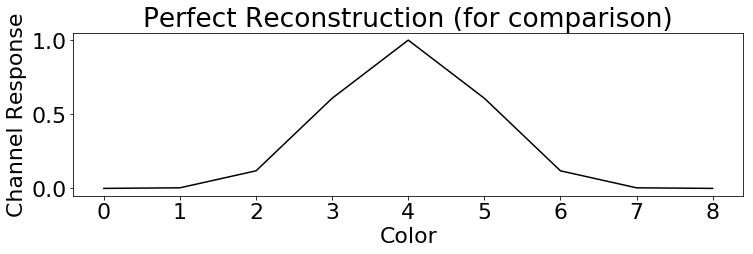

test: avg MAE: 0.709402992338


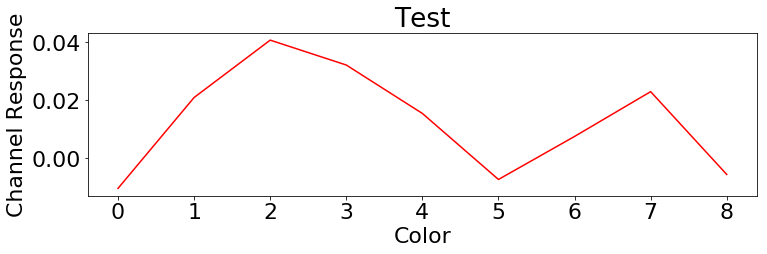

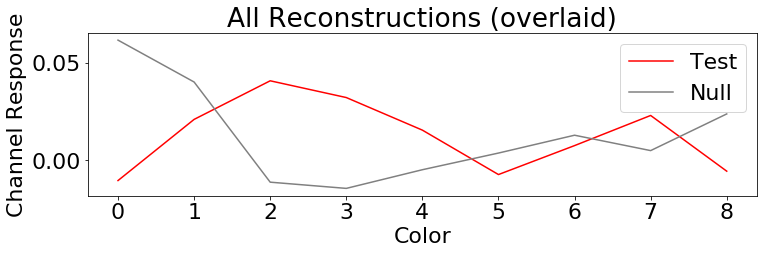

null: avg MAE: 0.727090141742


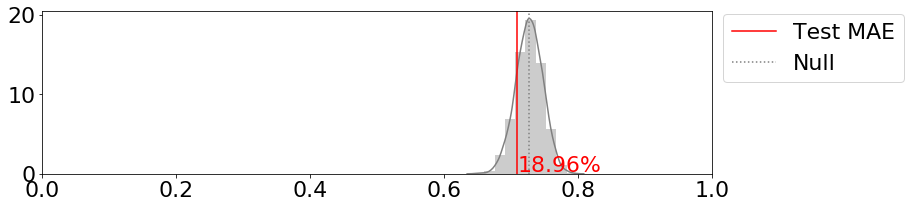

% overlap w/ null distribution (10000 permutations): 18.96%
basically, this means p=0.190
meaning that test reconstructions are not significantly different from null reconstructions.


In [3968]:
## Cross-validation ##

if len(trial_by_vox[np.isnan(trial_by_vox)]) > 0:
    trial_by_vox[np.isnan(trial_by_vox)] = np.nanmean(trial_by_vox)
    print("replacing NaNs with avg beta")
tst = trial_by_vox
tstf = trial_features
cr_tst = np.linalg.lstsq(full_saved_weights.T , tst.T, rcond=None)[0].T

# Plot perfect reconstruction for comparison
perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]
plt.plot(perfect_recon,color='k')
plt.title("Perfect Reconstruction (for comparison)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Avg. reconstructions (testing)
cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
for trial in np.arange(cr_tst.shape[0]):
    trial_actual[trial] = int(tstf[trial]/(360/nchannels))
    trial_guess[trial] = np.argmax(cr_tst[trial,:])
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
trial_diff = np.abs(trial_actual-trial_guess)
trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
#trial_diff[trial_diff>2] = 2
tst_mae = np.mean(trial_diff)
print("test: avg MAE: {}".format(tst_mae))
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r')
plt.title("Test")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

# Null distribution testing
numperms = 10000
cr_center_null = np.empty_like(cr_tst)
trial_actual = np.full(cr_tst.shape[0],999)
trial_guess = np.full(cr_tst.shape[0],999)
null_mae = np.full(numperms,np.nan)
for perm in np.arange(numperms):
    tstf_shuffle = np.random.permutation(tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-perfect_recon[trial_diff+shiftby]
    #trial_diff[trial_diff>2] = 2
    null_mae[perm] = np.mean(trial_diff)
    
plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
plt.title("All Reconstructions (overlaid)")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend()
plt.show()

print("null: avg MAE: {}".format(np.mean(null_mae)))

tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

sns.distplot(null_mae,color='gray',bins=10)
plt.axvline(tst_mae,color='red',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
plt.xlim([0,1])
plt.show()

print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
print("basically, this means p={:.3f}".format(tst_overlap/100))
if tst_overlap < 5:
    print("meaning that test reconstructions significantly different from null reconstructions!")
else:
    print("meaning that test reconstructions are not significantly different from null reconstructions.")

# testing out getting into different templates

In [4398]:
subject_id = '102'

mprage = nib.load('/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-{}/anat/sub-{}_desc-preproc_T1w.nii.gz'.format(subject_id,subject_id))
mprage0 = mprage.get_data()
print(mprage.shape)

mydata = np.load(out_dir + '/singletrial_encoder_wf/_subject_id_{}/{}'.format(subject_id,'whole_brain') + '.npy')[()]

roi = 'lh.V1v.nii'
mask = nib.load(base_dir + '/sub-' + subject_id + '/retmaps/' + roi)

spmmat = loadmat(out_dir + '/encoder_sanity_ROI_wf/_subject_id_{}/level1estimate/SPM.mat'.format(subject_id),
                struct_as_record=False)

names = np.array([i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]])

for c in range(1):
    for run in range(1):
        for n_idx in range(len(names)):
            if (names[n_idx] == "Sn({}) {}*bf(1)".format(run+1,c+1)):
                beta_idx = n_idx+1
        img = nib.load(out_dir+'/encoder_sanity_ROI_wf/_subject_id_{}/level1estimate/beta_000{}.nii'.format(subject_id,beta_idx))

        # what is the voxel coordinate in the beta image corresponding to the mask? (nearest neighbor)
        mask_vox2img_vox = np.linalg.inv(img.affine).dot(mask.affine)
        mask_idx = np.where(mask_data>0)
        mask_vox = np.array([mask_idx[0][:],mask_idx[1][:],mask_idx[2][:]]).T
        new_mask = np.unique(np.round(nib.affines.apply_affine(mask_vox2img_vox, mask_vox)),axis=0)

        betas = img.get_data()
        betas = betas[map(int,new_mask[:,0]),map(int,new_mask[:,1]),map(int,new_mask[:,2])]
    #betas[c,:] = img.get_data()



(176, 224, 256)


IndexError: index 71 is out of bounds for axis 0 with size 71

In [4313]:
trial_cond = np.array(mydata['cond'])/40

img = np.full(10,np.nan)
for c in range(10):
    if c == 9:
        img[c] = np.nanmean(mydata['betas'][:,:,:,np.where(np.isnan(trial_cond))[0]])
    else:
        img[c] = np.nanmean(mydata['betas'][:,:,:,np.where(trial_cond==c)[0]])

#blankimg = np.nanmean(blank,axis=3)
#colorimg = np.nanmean(color,axis=3)
#colormap = nib.Nifti1Image(np.nanmean(color,axis=3), mydata['affine'])


In [ ]:
# sanity

blank = mydata['betas'][:,:,:,0:120]
color = mydata['betas'][:,:,:,121:240]

blankimg = np.nanmean(blank,axis=3)
colorimg = np.nanmean(color,axis=3)

statmap = nib.Nifti1Image(np.nanmean(color,axis=3) - np.nanmean(blank,axis=3), mydata['affine'])

#plot_stat_map(statmap,bg_img=mprage)

test = niwidgets.NiftiWidget(statmap)
bg_img = niwidgets.NiftiWidget(mprage)
test.nifti_plotter(plotting_func=nip.plot_stat_map,
                   bg_img='/lab/Paul/ContIEM/bids/dockerout/out/fmriprep/sub-102/anat/sub-102_desc-preproc_T1w.nii.gz',
                   threshold=(0.00, 12.0, 0.01),
                   colormap='jet')

In [609]:
print(mydata['betas'].shape)
np.isnan(mydata['cond']).shape

(77, 82, 74)


(240,)

In [665]:
from nilearn.image import resample_to_img
